# 2024Q2报告

使用em的业绩报告数据。

In [1]:
import datetime
import logging
from pathlib import Path
import sqlite3
import time

import akshare as ak
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

logging.basicConfig(level=logging.WARNING)


In [2]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [3]:
# def begin with plot, always use widedf
# def begin with draw, always use other df

def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    return (col_profile)

def plot_barh(df, title=None, fmt=''):
    """
    plot barh, x axis on top. If title not set, use df.columns[0] as title.
    """
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=fmt)
    ax.xaxis.tick_top()
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)

def plot_subs(df:pd.DataFrame, cols:int, kind:str = 'barh', sharex:bool = True, sharey:bool = True):
    """
    plot subplot.
    df: must be tidied, keep only data cols
    cols: how many columns in the subplots
    """
    s = df.shape
    rows = int(s[1]/cols)+1
    lay = (rows, cols)
    height = s[0]*0.3*rows
    axs = df.plot(kind=kind, subplots=True, layout=lay, figsize=(10,height), sharex=sharex, sharey=True, fontsize=8, legend=False)
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def plot_muti_lines(df: pd.DataFrame, logy:bool = False):
    """
    multiline chart
    legend order by last column, and in left side.
    """
    height = max(0.3*len(df.T), 5)
    ax = df.plot.line(figsize=(10, height), logy=logy)
    handles, labels = ax.get_legend_handles_labels()
    # h = list(df.iloc[-1].sort_values(ascending=False).index.values)
    ol = list(df.iloc[-1].sort_values(ascending=False).index.values)
    oh = [handles[labels.index(label)] for label in ol]
    ax.legend(oh, ol, loc='upper left')
    plt.show(ax)

def plot_cdf(df:pd.DataFrame, col:int = -1, logx : bool = False):
    x = df.iloc[col, :].sort_values()
    y = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x, y)
    if logx:
        ax.set_xscale('log')  # 设置 x 轴为对数轴
    ax.twinx().set_ylim(0, len(x))

    plt.show()

def draw_vhists(df:pd.DataFrame, bins:int = 14, fig_cols:int =3):
    """
    df: must be tidied, keep only numeric data cols only.
    fig_cols: how many columns in the subplots
    """
    def divide_or_ceil(a:int, b:int):
        if a % b == 0:
            return a // b
        else:
            return (a // b) + 1
    df_cols = len(df.columns)
    rows = divide_or_ceil(df_cols, fig_cols)
    height = 0.3*bins*rows+1
    fig, axs = plt.subplots(rows, fig_cols, figsize=(10,height))
    axs = axs.flatten()
    for i in range(df_cols):
        axs[i].hist(df.iloc[:,i], bins=bins, edgecolor='white', linewidth=1.2, orientation='horizontal')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def cross_dfs(df:pd.DataFrame, to_cross:list):
    """
    求出若干个df的交集，每个df都有cname列。
    """
    res = set(df['cname'])
    for d in to_cross:
        res &= set(d['cname'])
    ret_df = df[df['cname'].isin(res)]
    return ret_df

def de_banks(df:pd.DataFrame):
    ret = df[~df['cname'].str.contains(r'银行|商行|证券')]
    print(f'total: {len(df)} | banks: {len(df)-len(ret)} | non-banks: {len(ret)}')
    return ret

def get_slope(s:pd.Series):
    y = s.dropna().values  # y 值为序列的值
    x = np.arange(len(y))  # x 值为序列的索引
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    # 计算残差
    y_pred = slope * x + intercept
    residuals = y - y_pred
    # 计算残差的标准差（Residual Standard Error）
    residual_std_dev = np.std(residuals)
    ret = slope / (residual_std_dev + 1e-10)  # 避免除以零
    return ret

def cross_index(ss):
    crossed = set(ss[0].index)
    for s in ss[1:]:
        crossed = crossed & set(s.index)
    return ss[0].loc[list(crossed)]

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.6f} seconds to run.")
        return result
    return wrapper

In [4]:
class YJBB:
    ALL_COLS = ['序号', '股票代码', '股票简称', '每股收益', '营业收入-营业收入', '营业收入-同比增长', '营业收入-季度环比增长', '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', '每股净资产', '净资产收益率', '每股经营现金流量', '销售毛利率', '所处行业', '最新公告日期']
    
    def __init__(self):
        self.codedf = self.get_codes()
        self.df = self.get_valid_reports()
        self.code_link_dict, self.code_indu_dict = self.get_code_dict()
        self.tidied = self.quater_data()
        self.npm = self.tidied.pivot_table(index='rdate', columns='code', values='npm', aggfunc='first')
        self.revenue = self.tops(self.tidied, 300, 'revenue')
        self.profit = self.tops(self.tidied, 300, 'profit')

    def get_data(self):
        cols = ['股票代码', '股票简称', '营业收入-营业收入','净利润-净利润', '所处行业', 'rdate']
        cols_str = ', '.join([f'"{col}"' if '-' in col else col for col in cols])
        conn = sqlite3.connect('../yjbb.db')
        df = pd.read_sql_query(f'select {cols_str} from yjbb_data', conn)
        conn.close()
        df.columns = ['code', 'cname', 'revenue', 'profit', 'industry', 'rdate']
        df['cname'] = df['cname'].str.replace(' ', '')
        df.replace(0, np.nan, inplace=True)

        return df
    
    def get_codes(self):
        current_time = datetime.datetime.now().timestamp()
        codes = Path('codes.csv')
        if codes.exists() :
            diff = current_time - codes.stat().st_mtime
            if diff < 3600*24:
                df = pd.read_csv(codes, dtype={'code': str})
                return df
        df = ak.stock_zh_a_spot_em()[['代码', '名称','市盈率-动态', '市净率', '总市值']]
        df.columns = ['code', 'cname', 'pe', 'pb', 'mv']
        df['cname'] = df['cname'].str.replace(' ', '')
        df.to_csv(codes, index=False)
        return df
    
    def get_valid_reports(self):
        """
        报告df中含有新三板的数据，不需要用。
        codedf中含有退市的代码，这些代码没有报告。
        报告数据使用这两者的交集。
        """
        df = self.get_data()
        report_codes = df['code'].unique()
        trade_codes = self.codedf['code'].unique()
        crossed_codes = set(report_codes) & set(trade_codes)
        df = df.loc[df['code'].isin(crossed_codes)]
        return df
    
    def get_code_dict(self):
        codes = self.df.groupby('code')[['cname', 'industry']].first()
        codes['link'] = [f'<a href="https://data.eastmoney.com/stockdata/{x.index}.html" target="_blank">{x.cname}</a>' for x in codes.itertuples()]
        code_link_dict = codes['link'].to_dict()
        code_indu_dict = codes['industry'].to_dict()
        return (code_link_dict, code_indu_dict)
    
    def quater_data(self):
        """
        按季度整理数据，使收入和利润可以进行按季度进行比较。
        em的数据，目前看只有profit和revenue具有可用性。所以只整理这两项。
        可供分析的再加上一个计算得来的利润率。
        """
        def tidy_data(df:pd.DataFrame, item : str):
            """
            按季度整理数据，使收入和利润可以进行按季度进行比较。
            """
            dft = df.pivot_table(index='rdate', columns='code', values=item, aggfunc='first', observed=True)
            dft = dft.apply(pd.to_numeric, errors='coerce') # 数据中可能有空格
            long, wide = dft.shape
            logging.warning(f'{item} 代码总数: {wide}')
            nan_count_s = dft.isna().sum()
            logging.warning(f'数据齐全: {len(nan_count_s[nan_count_s==0])}')
            to_tidy_s = nan_count_s[nan_count_s > 0].index
            logging.warning(f'需要整理: {len(to_tidy_s)}')
            # 将有空值的code从最近一期往前数，找到第一个空值的索引
            to_tidy_df = dft.loc[:, to_tidy_s].sort_index(ascending=False)
            first_null_index_s  = to_tidy_df.reset_index(drop=True).isna().idxmax()
            # 小于7期的设为全空，可以去掉。
            first_null_index_s = first_null_index_s.apply(lambda x: x if x >7 else 0)
            # 将第一个空索引号及以前期的数据设为空值，就得到了连续报告期的数量。
            mask = pd.DataFrame({k: [True] * v + [False] * (long - v) for k, v in first_null_index_s.items()})
            mask.index = to_tidy_df.index
            tided_df = to_tidy_df[mask].dropna(how='all', axis=1).sort_index()
            logging.warning(f'删除连续数据少于8期: {len(to_tidy_df.T)-len(tided_df.T)}')
            tided_df = pd.concat([dft.loc[:, nan_count_s[nan_count_s == 0].index], tided_df], axis=1)
            logging.warning(f'完成整理后总数: {len(tided_df.T)}')
            #原来的季报数据为当年加总，转换为单季度数据。
            to_diff_df = tided_df.reset_index(drop=True)
            diffed_df = (to_diff_df.groupby(to_diff_df.index // 4)
                         .diff()
                         .fillna(to_diff_df)
                         )
            diffed_df.index = tided_df.index
            # 4个季度滚动相加做为季度化的年度数据，从而进行季度对比。
            rolled_df = diffed_df.rolling(4).sum().dropna(how='all')
            ret = rolled_df.melt(value_name=item, ignore_index=False).reset_index()
            logging.warning(f'{item} tidy complete!')
            return ret
        
        df = self.df
        profit = tidy_data(df, 'profit')
        revenue = tidy_data(df, 'revenue')
        crossed = set(profit['code'].unique()) - set(revenue['code'].unique())
        logging.warning(f'删除有利润无收入的（基本为科创板）: {crossed}')
        profit = profit.loc[~profit['code'].isin(list(crossed))]
        logging.warning(f'profit len: {len(profit)} | revenue len: {len(revenue)}')
        ret = profit.merge(revenue, on=['code', 'rdate'], how='left')
        ret['npm'] = 100 * ret['profit'] / ret['revenue']
        ret.to_pickle('keydata.pkl')
        return ret

    def gt_all_years(self, npm:int = 15, qs:int = 20):
        """
        find all companies that have been greater than n in all years
        """
        df = self.npm
        res = pd.DataFrame({
            'total': df.count(),
            'count': (df > npm).sum()
        })
        res['pct'] = res['count'] / res['total']
        res['gt'] = npm
        ret = res[(res['pct'] == 1) & (res['count'] > qs)]['gt']
        ret = ret.to_frame().reset_index()
        return ret
        
    def gt_per_year(self, n:int = 15):
        """
        plot barh of count of companies that have been greater than n in each year
        """
        df = self.npm
        s = (df > n).sum(axis=1)
        total = df.count(axis=1)
        res = s.to_frame(f'count great than {n}')
        res['pct'] = res[f'count great than {n}'] / total
        plot_subs(res,2, sharex=False)

    def fold_a_col(self, s:pd.Series, n:int = 8, show_num:bool = True, fmt = '{:.2f}'):
        """
        fold a column into n columns
        input series must be indexed by cname, and values are numbers
        output: cname + value in every cell
        """
        df = s.dropna().sort_values(ascending=False).to_frame()
        if show_num:
            df['code'] = df.index.map(lambda x: self.code_link_dict[x]) + ' ' + df.iloc[:,-1].map(lambda x: fmt.format(x))
        else:
            df['code'] = df.index.map(lambda x: self.code_link_dict[x])
        df['group'] = [i % n for i in range(len(df))]
        folded = pd.concat([g.reset_index(drop=True)[['code']] for _, g in df.groupby('group')], axis=1)
        # 如果数量很少，不够10列显示，则有几个算几列。
        col_name = len(df) if len(df) < n else n
        folded.columns = [i+1 for i in range(col_name)]
        folded.replace(np.nan, '', inplace=True)
        print(f'total: {len(df)} | from {round(df.iloc[:,0].max(), 2)} to {round(df.iloc[:,0].min(), 2)}')
        return folded.style
    
    def indu_count(self, s:pd.Series, n:int = 20):
        indu = s.map(lambda x: self.code_indu_dict.get(x, 'ohter'))
        indu_count = indu.value_counts().sort_values(ascending=True)
        n = min(n, len(indu_count))
        print(f'total: {len(indu_count)} | top {n} : {indu_count.tail(n).sum() / indu_count.sum() * 100:.2f}%')
        plot_barh(indu_count.tail(n).to_frame('count'))

    def fold_list(self, l, cols):
        styled = [self.code_link_dict.get(x,'other') for x in l]
        rows = int(len(l)/cols) + 1
        fill = rows*cols - len(l)
        styled = styled + [np.nan]*fill
        df = pd.DataFrame({
            i: styled[i*cols:(i+1)*cols] for i in range(rows)
        })
        display(df.T.replace(np.nan, '').style)

    def get_df_slope(self, df):
        def calc_slope(df: pd.DataFrame):
            # 去除缺失值并转换为 numpy 数组
            y = df.values
            x = np.arange(y.shape[0])[:, np.newaxis]        
            # 添加常数项以进行线性回归
            A = np.hstack([x, np.ones((x.shape[0], 1))])        
            # 使用最小二乘法进行线性回归
            coefficients = np.linalg.lstsq(A, y, rcond=None)[0]
            slope = coefficients[0, :]
            intercept = coefficients[1, :]        
            # 计算预测值
            y_pred = x * slope + intercept        
            # 计算残差
            residuals = y - y_pred        
            # 计算残差的标准差（Residual Standard Error）
            residual_std_dev = np.std(residuals, axis=0)        
            # 避免除以零
            res = slope / (residual_std_dev + 1e-10)
            ret = pd.Series(res, index = df.columns)        
            return ret

        df = df.dropna(thresh=20, axis=1) # keep cols at least have 20 data
        sorted_cols = df.isna().sum().sort_values()
        df_sorted = df[sorted_cols.index]
        cord = sorted_cols.value_counts().sort_index().cumsum().to_frame('col_end').reset_index(names = 'row_begin')
        cord['col_begin'] = cord['col_end'].shift(periods=1, fill_value=0)
        slope_s = pd.concat(
            [calc_slope(df_sorted.iloc[t.row_begin:, t.col_begin:t.col_end]) for t in cord.itertuples()]
                )
        return slope_s
    
    def tops(self, df:pd.DataFrame, n:int, col:str):
        sel = df[['rdate', 'code', col]]
        total_qs_s = sel.dropna()['code'].value_counts().to_frame('total')
        mostn_s = sel.sort_values(['rdate', col], ascending=[1, 0]).groupby('rdate', observed=True)[['code', col]].nth[:n]['code'].value_counts().sort_values(ascending=0)
        mostn_df = mostn_s.to_frame('hits')
        mostn_df = mostn_df.join(total_qs_s)
        mostn_df['pct'] = mostn_df['hits'] / mostn_df['total']
        mostn_df['item'] = col
        mostn_df = mostn_df.reset_index(names='code')
        any_q = mostn_df.set_index('code')['hits']
        all_q = mostn_df[mostn_df['pct'] >=1].set_index('code')['hits']

        dft = df.pivot_table(index='rdate', columns='code', values=col, observed=True)

        def total_pct():
            total = sel.groupby('rdate', observed=True)[col].sum()
            plot_tolal = total.plot.line(figsize=(10,5), title=col)
            plt.show()
            plot_pct = total.pct_change().plot.line(figsize=(10,5), title=col+' change')
            plt.show()

        def top30():
            df = pd.DataFrame({
                l: col.nlargest(30).index.values for l, col in dft.T.items()
            }).iloc[:,-8:]
            df_show = df.map(lambda x: self.code_link_dict.get(x, 'other')).style
            display(f'-------最近8期{col}前30------')
            display(df_show)
            melted = df.melt(value_name='code')
            self.indu_count(melted['code'])
        
        # 20期以上的从第20期向后逐年计算slop,最后计算平均。
        dft = dft.dropna(thresh=20,axis=1)
        dft_len = len(dft)
        slop = pd.concat(
            [self.get_df_slope(dft.iloc[:i,:]) for i in range(20, dft_len)],
            axis=1
        ).mean(1).nlargest(n)
        slop_cross_any_q = slop[list(set(any_q.index.values) & set(slop.index.values))]
        slop_cross_all_q = slop[list(set(all_q.index.values) & set(slop.index.values))]
        
        def topn_s():
            display(f'------所有上过榜的------')
            display(self.fold_a_col(any_q,fmt='{:.0f}'))
            self.indu_count(any_q.index)
            display(f'------每期都上榜的------')
            display(self.fold_a_col(all_q, show_num=False))
            self.indu_count(all_q.index)

        def slop_s():
            display('------增长情况------')
            display(f'增长top{n}')
            display(self.fold_a_col(slop,fmt='{:.2f}'))
            self.indu_count(slop.index)

            display(f'增长top{n},同时上榜过{col} top{n}')
            if len(slop_cross_any_q)>0:
                display(self.fold_a_col(slop_cross_any_q,fmt='{:.2f}'))
                self.indu_count(slop_cross_any_q.index)
            else: display('无交集')

            display(f'增长top{n},同时{col}一直top{n}')
            if len(slop_cross_all_q)>0:
                display(self.fold_a_col(slop_cross_all_q,fmt='{:.2f}'))
                self.indu_count(slop_cross_all_q.index)
            else: display('无交集')

        data = [any_q.index, all_q.index, slop.index, slop_cross_any_q.index,slop_cross_all_q.index]

        return (data, total_pct, top30, topn_s, slop_s)
    
    def loss_pct(self, df:pd.DataFrame):
        profit = df.pivot_table(index='rdate', columns='code', values='profit', observed=True)
        # count_s = profit.count(axis=1)
        count_pct_s = (profit < 0).mean(axis=1) # 一条命令计算亏损家数的比例
        # count_pct_s = count_neg_s / count_s
        posi_value_s = profit[profit > 0].sum(axis=1)
        total_value_s = profit.sum(axis=1)
        value_pct_s = (posi_value_s - total_value_s) / posi_value_s
        res  = pd.DataFrame([count_pct_s, value_pct_s], index=['count', 'value']).T
        plot_muti_lines(res)

    def cross_rev_pro(self):
        crossed = [list(set(a) & set(b)) for a, b in zip(self.revenue[0],self.profit[0])]
        for i in crossed:
            self.fold_list(i, 8)
            self.indu_count(pd.Series(i))
        

In [5]:
yjbb = YJBB()

## 收入

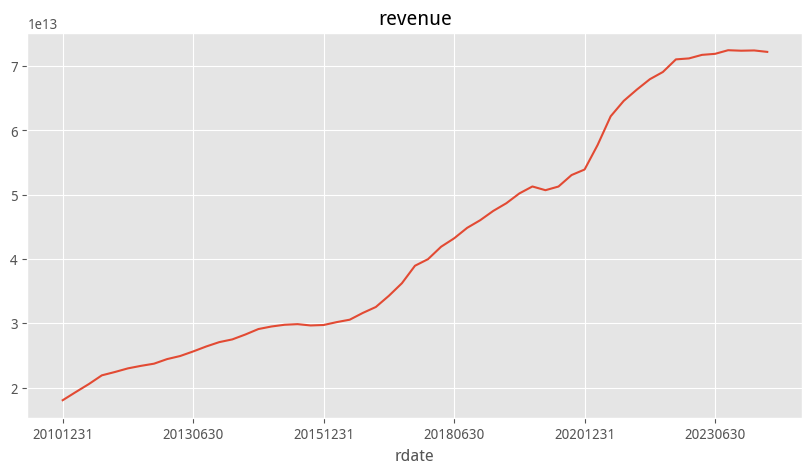

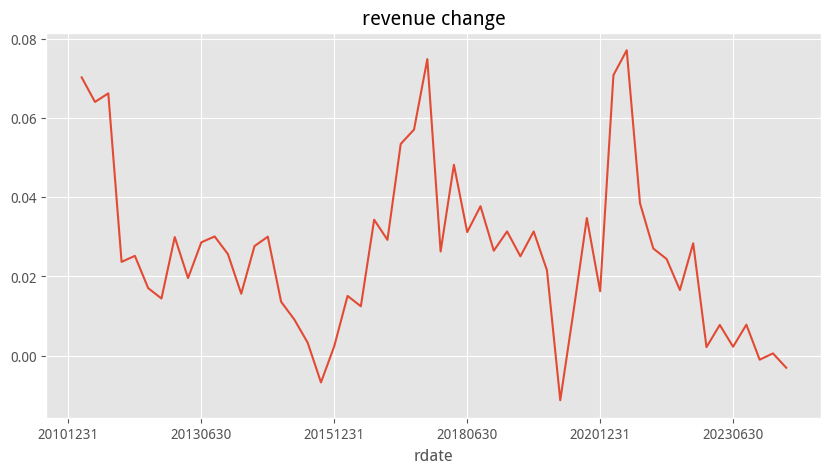

'-------最近8期revenue前30------'

,20220930,20221231,20230331,20230630,20230930,20231231,20240331,20240630
0,".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石化"
1,".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油"
2,".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国建筑"
3,".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国中铁"
4,".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国铁建"
5,".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安"
6,".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">建发股份",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">中国人寿"
7,".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">建发股份",".html"" target=""_blank"">建发股份",".html"" target=""_blank"">建发股份",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行"
8,".html"" target=""_blank"">建发股份",".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行"
9,".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国交建",".html"" target=""_blank"">上汽集团",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建发股份",".html"" target=""_blank"">中国交建",".html"" target=""_blank"">中国交建"


total: 16 | top 16 : 100.00%


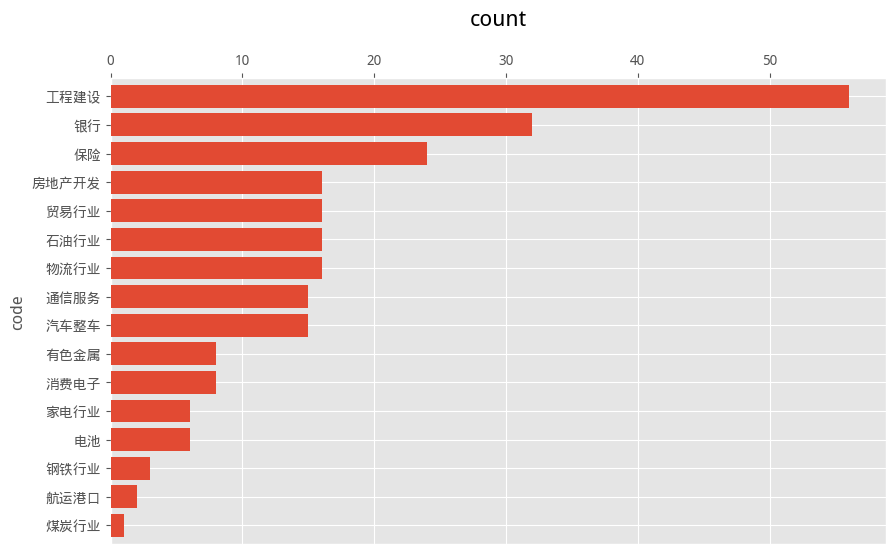

'------所有上过榜的------'

total: 556 | from 55 to 1


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">云天化 55",".html"" target=""_blank"">南方航空 55",".html"" target=""_blank"">中远海控 55",".html"" target=""_blank"">中国国航 55",".html"" target=""_blank"">浦发银行 55",".html"" target=""_blank"">万科A 55",".html"" target=""_blank"">中集集团 55",".html"" target=""_blank"">TCL科技 55"
1,".html"" target=""_blank"">铜陵有色 55",".html"" target=""_blank"">新希望 55",".html"" target=""_blank"">福田汽车 55",".html"" target=""_blank"">中国重工 55",".html"" target=""_blank"">民生银行 55",".html"" target=""_blank"">中信银行 55",".html"" target=""_blank"">华菱钢铁 55",".html"" target=""_blank"">京东方A 55"
2,".html"" target=""_blank"">海大集团 55",".html"" target=""_blank"">大唐发电 55",".html"" target=""_blank"">格力电器 55",".html"" target=""_blank"">上海电气 55",".html"" target=""_blank"">华谊集团 55",".html"" target=""_blank"">锡业股份 55",".html"" target=""_blank"">万华化学 55",".html"" target=""_blank"">柳钢股份 55"
3,".html"" target=""_blank"">一汽解放 55",".html"" target=""_blank"">新兴铸管 55",".html"" target=""_blank"">东方电气 55",".html"" target=""_blank"">上海医药 55",".html"" target=""_blank"">中化国际 55",".html"" target=""_blank"">包钢股份 55",".html"" target=""_blank"">国电电力 55",".html"" target=""_blank"">四川长虹 55"
4,".html"" target=""_blank"">上海石化 55",".html"" target=""_blank"">华电国际 55",".html"" target=""_blank"">本钢板材 55",".html"" target=""_blank"">比亚迪 55",".html"" target=""_blank"">云南铜业 55",".html"" target=""_blank"">中联重科 55",".html"" target=""_blank"">长安汽车 55",".html"" target=""_blank"">三一重工 55"
5,".html"" target=""_blank"">厦门国贸 55",".html"" target=""_blank"">中国化学 55",".html"" target=""_blank"">海螺水泥 55",".html"" target=""_blank"">国机汽车 55",".html"" target=""_blank"">兖矿能源 55",".html"" target=""_blank"">新钢股份 55",".html"" target=""_blank"">光大银行 55",".html"" target=""_blank"">保利发展 55"
6,".html"" target=""_blank"">广汽集团 55",".html"" target=""_blank"">广州发展 55",".html"" target=""_blank"">华东医药 55",".html"" target=""_blank"">海亮股份 55",".html"" target=""_blank"">中信证券 55",".html"" target=""_blank"">首钢股份 55",".html"" target=""_blank"">安阳钢铁 55",".html"" target=""_blank"">紫金矿业 55"
7,".html"" target=""_blank"">伊利股份 55",".html"" target=""_blank"">江淮汽车 55",".html"" target=""_blank"">南钢股份 55",".html"" target=""_blank"">山东钢铁 55",".html"" target=""_blank"">中国中免 55",".html"" target=""_blank"">通威股份 55",".html"" target=""_blank"">云南白药 55",".html"" target=""_blank"">金发科技 55"
8,".html"" target=""_blank"">大秦铁路 55",".html"" target=""_blank"">兴业银行 55",".html"" target=""_blank"">华域汽车 55",".html"" target=""_blank"">物产中大 55",".html"" target=""_blank"">远大控股 55",".html"" target=""_blank"">海信视像 55",".html"" target=""_blank"">温氏股份 55",".html"" target=""_blank"">长江电力 55"
9,".html"" target=""_blank"">中金黄金 55",".html"" target=""_blank"">金隅集团 55",".html"" target=""_blank"">华锦股份 55",".html"" target=""_blank"">贵州茅台 55",".html"" target=""_blank"">永辉超市 55",".html"" target=""_blank"">粤电力A 55",".html"" target=""_blank"">国药一致 55",".html"" target=""_blank"">老凤祥 55"


total: 77 | top 20 : 61.15%


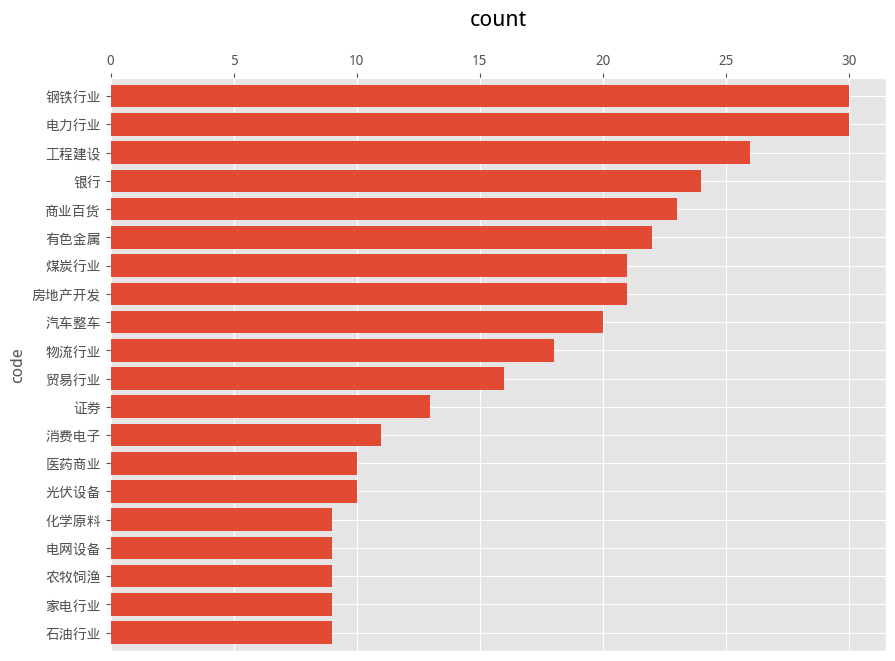

'------每期都上榜的------'

total: 186 | from 55 to 8


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">中国石化",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">江西铜业",".html"" target=""_blank"">ST易购",".html"" target=""_blank"">上海建工",".html"" target=""_blank"">中国东航"
1,".html"" target=""_blank"">招商银行",".html"" target=""_blank"">中煤能源",".html"" target=""_blank"">中兴通讯",".html"" target=""_blank"">建发股份",".html"" target=""_blank"">中国中车",".html"" target=""_blank"">马钢股份",".html"" target=""_blank"">海尔智家",".html"" target=""_blank"">潍柴动力"
2,".html"" target=""_blank"">上海电气",".html"" target=""_blank"">格力电器",".html"" target=""_blank"">大唐发电",".html"" target=""_blank"">海大集团",".html"" target=""_blank"">京东方A",".html"" target=""_blank"">华菱钢铁",".html"" target=""_blank"">中信银行",".html"" target=""_blank"">民生银行"
3,".html"" target=""_blank"">中国重工",".html"" target=""_blank"">福田汽车",".html"" target=""_blank"">新希望",".html"" target=""_blank"">铜陵有色",".html"" target=""_blank"">TCL科技",".html"" target=""_blank"">中集集团",".html"" target=""_blank"">万科A",".html"" target=""_blank"">浦发银行"
4,".html"" target=""_blank"">比亚迪",".html"" target=""_blank"">本钢板材",".html"" target=""_blank"">华电国际",".html"" target=""_blank"">上海石化",".html"" target=""_blank"">四川长虹",".html"" target=""_blank"">国电电力",".html"" target=""_blank"">包钢股份",".html"" target=""_blank"">中化国际"
5,".html"" target=""_blank"">上海医药",".html"" target=""_blank"">东方电气",".html"" target=""_blank"">新兴铸管",".html"" target=""_blank"">一汽解放",".html"" target=""_blank"">柳钢股份",".html"" target=""_blank"">万华化学",".html"" target=""_blank"">锡业股份",".html"" target=""_blank"">华谊集团"
6,".html"" target=""_blank"">海亮股份",".html"" target=""_blank"">华东医药",".html"" target=""_blank"">广州发展",".html"" target=""_blank"">广汽集团",".html"" target=""_blank"">保利发展",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">新钢股份",".html"" target=""_blank"">兖矿能源"
7,".html"" target=""_blank"">国机汽车",".html"" target=""_blank"">海螺水泥",".html"" target=""_blank"">中国化学",".html"" target=""_blank"">厦门国贸",".html"" target=""_blank"">三一重工",".html"" target=""_blank"">长安汽车",".html"" target=""_blank"">中联重科",".html"" target=""_blank"">云南铜业"
8,".html"" target=""_blank"">物产中大",".html"" target=""_blank"">华域汽车",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">大秦铁路",".html"" target=""_blank"">金发科技",".html"" target=""_blank"">云南白药",".html"" target=""_blank"">通威股份",".html"" target=""_blank"">中国中免"
9,".html"" target=""_blank"">山东钢铁",".html"" target=""_blank"">南钢股份",".html"" target=""_blank"">江淮汽车",".html"" target=""_blank"">伊利股份",".html"" target=""_blank"">紫金矿业",".html"" target=""_blank"">安阳钢铁",".html"" target=""_blank"">首钢股份",".html"" target=""_blank"">中信证券"


total: 49 | top 20 : 75.81%


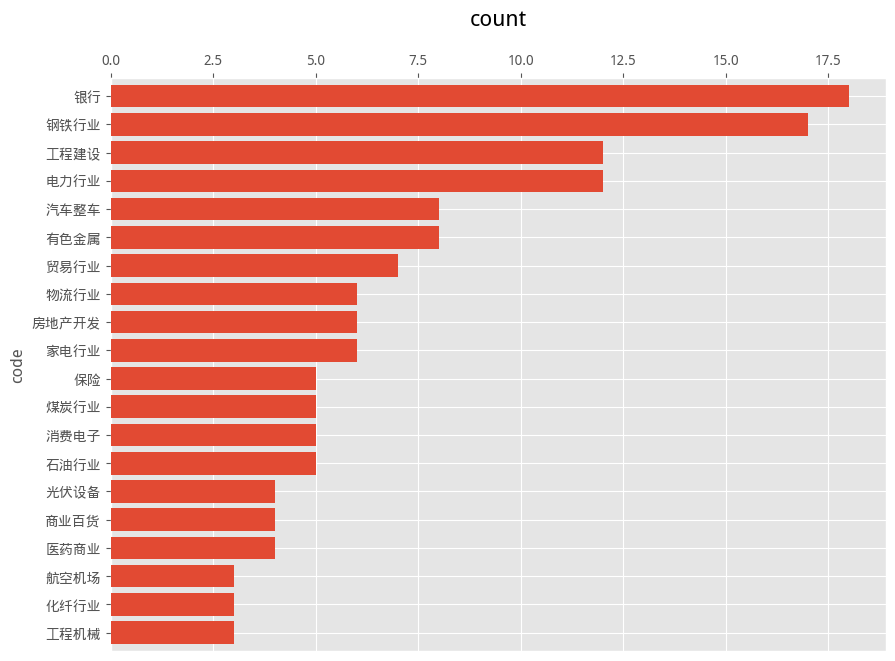

'------增长情况------'

'增长top300'

total: 300 | from 1.81 to 0.43


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">永辉超市 1.81",".html"" target=""_blank"">英特集团 1.57",".html"" target=""_blank"">金山办公 1.46",".html"" target=""_blank"">云南白药 1.39",".html"" target=""_blank"">健友股份 1.32",".html"" target=""_blank"">玉禾田 1.19",".html"" target=""_blank"">华东医药 1.18",".html"" target=""_blank"">上海医药 1.17"
1,".html"" target=""_blank"">广安爱众 1.15",".html"" target=""_blank"">恩华药业 1.15",".html"" target=""_blank"">中国建筑 1.14",".html"" target=""_blank"">安图生物 1.07",".html"" target=""_blank"">设研院 1.01",".html"" target=""_blank"">泛微网络 0.95",".html"" target=""_blank"">心脉医疗 0.94",".html"" target=""_blank"">广电计量 0.93"
2,".html"" target=""_blank"">宇信科技 0.91",".html"" target=""_blank"">千金药业 0.91",".html"" target=""_blank"">东华软件 0.91",".html"" target=""_blank"">药石科技 0.90",".html"" target=""_blank"">昆药集团 0.90",".html"" target=""_blank"">长沙银行 0.88",".html"" target=""_blank"">丽珠集团 0.88",".html"" target=""_blank"">北京银行 0.88"
3,".html"" target=""_blank"">中国广核 0.88",".html"" target=""_blank"">航天电器 0.85",".html"" target=""_blank"">伊利股份 0.85",".html"" target=""_blank"">普门科技 0.85",".html"" target=""_blank"">广州酒家 0.84",".html"" target=""_blank"">华夏银行 0.84",".html"" target=""_blank"">侨银股份 0.82",".html"" target=""_blank"">新天绿能 0.81"
4,".html"" target=""_blank"">科顺股份 0.81",".html"" target=""_blank"">中宠股份 0.79",".html"" target=""_blank"">同仁堂 0.78",".html"" target=""_blank"">招商银行 0.78",".html"" target=""_blank"">通化东宝 0.78",".html"" target=""_blank"">安恒信息 0.78",".html"" target=""_blank"">安博通 0.77",".html"" target=""_blank"">数字认证 0.77"
5,".html"" target=""_blank"">中信银行 0.76",".html"" target=""_blank"">保利发展 0.75",".html"" target=""_blank"">深信服 0.74",".html"" target=""_blank"">新大正 0.73",".html"" target=""_blank"">宁波华翔 0.72",".html"" target=""_blank"">睿创微纳 0.72",".html"" target=""_blank"">东方电子 0.72",".html"" target=""_blank"">芯源微 0.71"
6,".html"" target=""_blank"">浦发银行 0.71",".html"" target=""_blank"">安集科技 0.70",".html"" target=""_blank"">圣农发展 0.70",".html"" target=""_blank"">天准科技 0.70",".html"" target=""_blank"">大参林 0.70",".html"" target=""_blank"">龙软科技 0.70",".html"" target=""_blank"">盘龙药业 0.69",".html"" target=""_blank"">宁波银行 0.68"
7,".html"" target=""_blank"">桃李面包 0.68",".html"" target=""_blank"">南微医学 0.68",".html"" target=""_blank"">捷昌驱动 0.68",".html"" target=""_blank"">常熟银行 0.68",".html"" target=""_blank"">迈为股份 0.68",".html"" target=""_blank"">光威复材 0.68",".html"" target=""_blank"">山东赫达 0.68",".html"" target=""_blank"">中炬高新 0.68"
8,".html"" target=""_blank"">*ST步高 0.67",".html"" target=""_blank"">佰仁医疗 0.67",".html"" target=""_blank"">汤臣倍健 0.67",".html"" target=""_blank"">正元智慧 0.67",".html"" target=""_blank"">健康元 0.66",".html"" target=""_blank"">康缘药业 0.65",".html"" target=""_blank"">迈瑞医疗 0.65",".html"" target=""_blank"">机器人 0.65"
9,".html"" target=""_blank"">海容冷链 0.65",".html"" target=""_blank"">青鸟消防 0.65",".html"" target=""_blank"">启明星辰 0.64",".html"" target=""_blank"">三全食品 0.64",".html"" target=""_blank"">贵州燃气 0.64",".html"" target=""_blank"">英联股份 0.64",".html"" target=""_blank"">中南传媒 0.64",".html"" target=""_blank"">海利尔 0.64"


total: 64 | top 20 : 66.00%


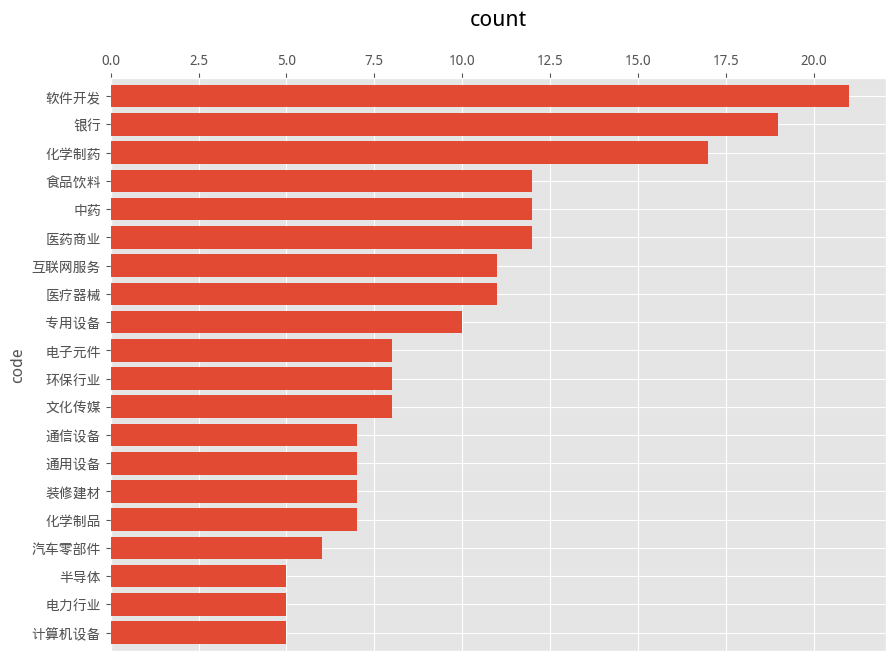

'增长top300,同时上榜过revenue top300'

total: 49 | from 1.81 to 0.45


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">永辉超市 1.81",".html"" target=""_blank"">英特集团 1.57",".html"" target=""_blank"">云南白药 1.39",".html"" target=""_blank"">华东医药 1.18",".html"" target=""_blank"">上海医药 1.17",".html"" target=""_blank"">中国建筑 1.14",".html"" target=""_blank"">北京银行 0.88",".html"" target=""_blank"">中国广核 0.88"
1,".html"" target=""_blank"">伊利股份 0.85",".html"" target=""_blank"">华夏银行 0.84",".html"" target=""_blank"">招商银行 0.78",".html"" target=""_blank"">中信银行 0.76",".html"" target=""_blank"">保利发展 0.75",".html"" target=""_blank"">浦发银行 0.71",".html"" target=""_blank"">宁波银行 0.68",".html"" target=""_blank"">*ST步高 0.67"
2,".html"" target=""_blank"">迈瑞医疗 0.65",".html"" target=""_blank"">平安银行 0.62",".html"" target=""_blank"">万科A 0.62",".html"" target=""_blank"">中国医药 0.59",".html"" target=""_blank"">海大集团 0.59",".html"" target=""_blank"">光大银行 0.59",".html"" target=""_blank"">建设银行 0.57",".html"" target=""_blank"">兴业银行 0.56"
3,".html"" target=""_blank"">复星医药 0.56",".html"" target=""_blank"">锡业股份 0.56",".html"" target=""_blank"">南京医药 0.56",".html"" target=""_blank"">中国太保 0.55",".html"" target=""_blank"">航天信息 0.55",".html"" target=""_blank"">福耀玻璃 0.53",".html"" target=""_blank"">交通银行 0.53",".html"" target=""_blank"">上海建工 0.53"
4,".html"" target=""_blank"">欧亚集团 0.53",".html"" target=""_blank"">中国电建 0.53",".html"" target=""_blank"">工商银行 0.52",".html"" target=""_blank"">长城汽车 0.52",".html"" target=""_blank"">九州通 0.52",".html"" target=""_blank"">中国银行 0.51",".html"" target=""_blank"">中国平安 0.51",".html"" target=""_blank"">海王生物 0.50"
5,".html"" target=""_blank"">甬金股份 0.49",".html"" target=""_blank"">歌尔股份 0.48",".html"" target=""_blank"">杭州银行 0.48",".html"" target=""_blank"">四川长虹 0.48",".html"" target=""_blank"">中国交建 0.47",".html"" target=""_blank"">大华股份 0.47",".html"" target=""_blank"">广州发展 0.46",".html"" target=""_blank"">上汽集团 0.45"
6,".html"" target=""_blank"">海康威视 0.45",,,,,,,


total: 20 | top 20 : 100.00%


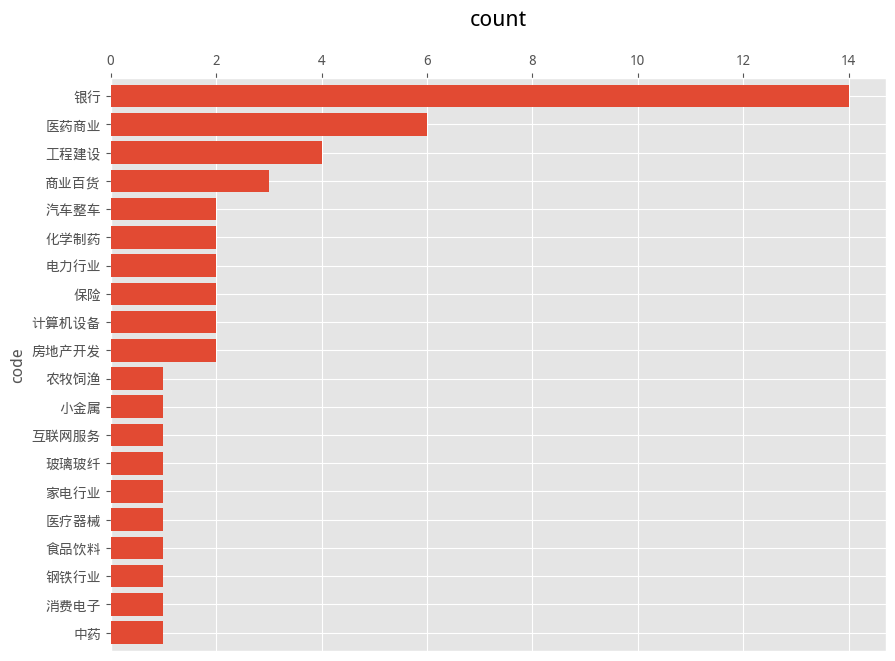

'增长top300,同时revenue一直top300'

total: 34 | from 1.81 to 0.45


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">永辉超市 1.81",".html"" target=""_blank"">云南白药 1.39",".html"" target=""_blank"">华东医药 1.18",".html"" target=""_blank"">上海医药 1.17",".html"" target=""_blank"">中国建筑 1.14",".html"" target=""_blank"">北京银行 0.88",".html"" target=""_blank"">中国广核 0.88",".html"" target=""_blank"">伊利股份 0.85"
1,".html"" target=""_blank"">华夏银行 0.84",".html"" target=""_blank"">招商银行 0.78",".html"" target=""_blank"">中信银行 0.76",".html"" target=""_blank"">保利发展 0.75",".html"" target=""_blank"">浦发银行 0.71",".html"" target=""_blank"">平安银行 0.62",".html"" target=""_blank"">万科A 0.62",".html"" target=""_blank"">海大集团 0.59"
2,".html"" target=""_blank"">光大银行 0.59",".html"" target=""_blank"">建设银行 0.57",".html"" target=""_blank"">兴业银行 0.56",".html"" target=""_blank"">锡业股份 0.56",".html"" target=""_blank"">南京医药 0.56",".html"" target=""_blank"">中国太保 0.55",".html"" target=""_blank"">交通银行 0.53",".html"" target=""_blank"">上海建工 0.53"
3,".html"" target=""_blank"">中国电建 0.53",".html"" target=""_blank"">工商银行 0.52",".html"" target=""_blank"">长城汽车 0.52",".html"" target=""_blank"">九州通 0.52",".html"" target=""_blank"">中国银行 0.51",".html"" target=""_blank"">中国平安 0.51",".html"" target=""_blank"">四川长虹 0.48",".html"" target=""_blank"">中国交建 0.47"
4,".html"" target=""_blank"">广州发展 0.46",".html"" target=""_blank"">上汽集团 0.45",,,,,,


total: 14 | top 14 : 100.00%


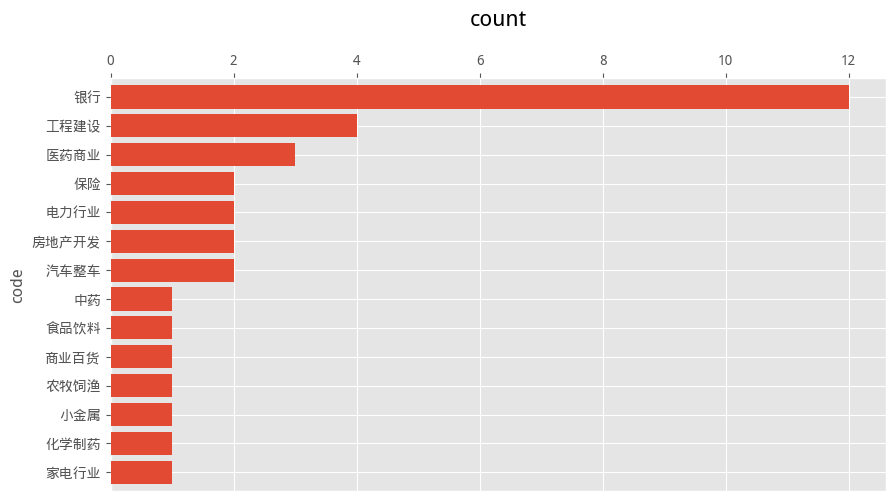

In [6]:
for i in yjbb.revenue[1:]:
    i()

## 利润

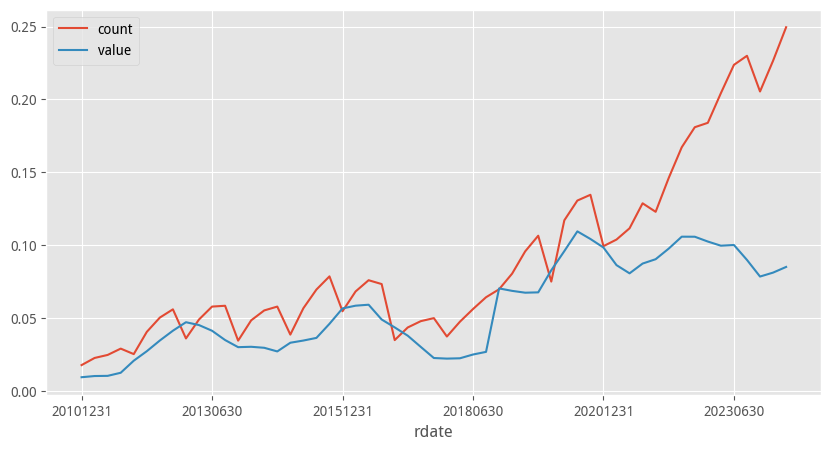

In [7]:
yjbb.loss_pct(yjbb.tidied)

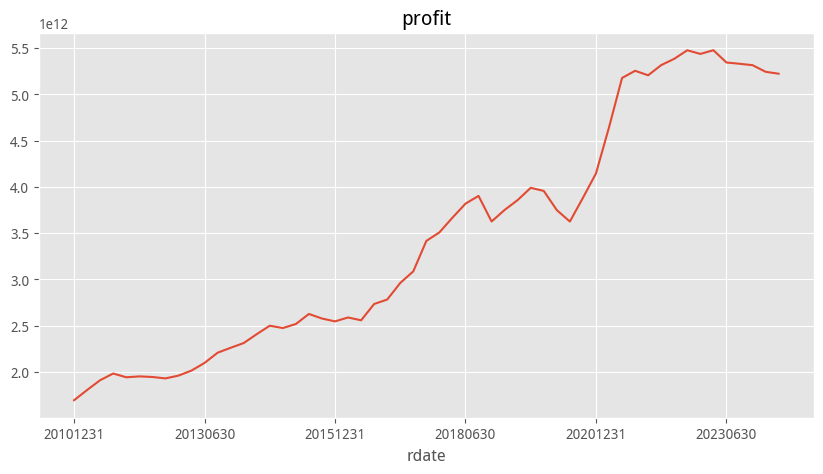

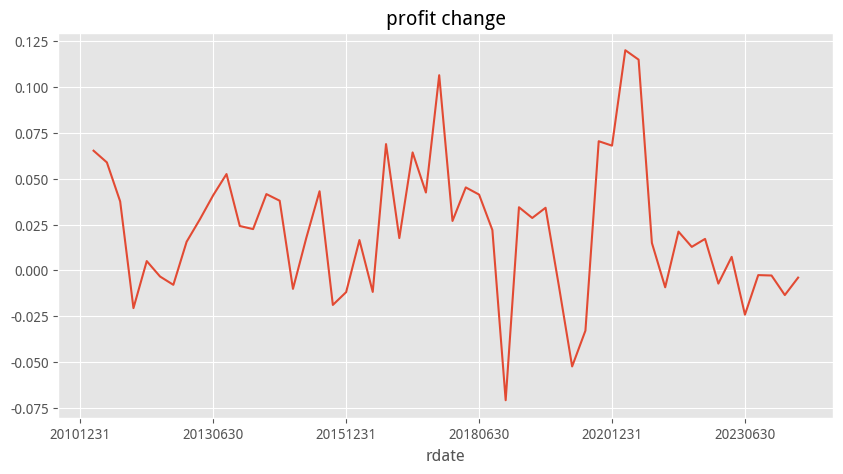

'-------最近8期profit前30------'

,20220930,20221231,20230331,20230630,20230930,20231231,20240331,20240630
0,".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">工商银行"
1,".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">建设银行"
2,".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">农业银行"
3,".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中国银行"
4,".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油",".html"" target=""_blank"">中国石油"
5,".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">招商银行"
6,".html"" target=""_blank"">中远海控",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">交通银行"
7,".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中远海控",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">邮储银行",".html"" target=""_blank"">邮储银行",".html"" target=""_blank"">中国平安"
8,".html"" target=""_blank"">交通银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">中远海控",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">邮储银行",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">邮储银行"
9,".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">邮储银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">贵州茅台"


total: 14 | top 14 : 100.00%


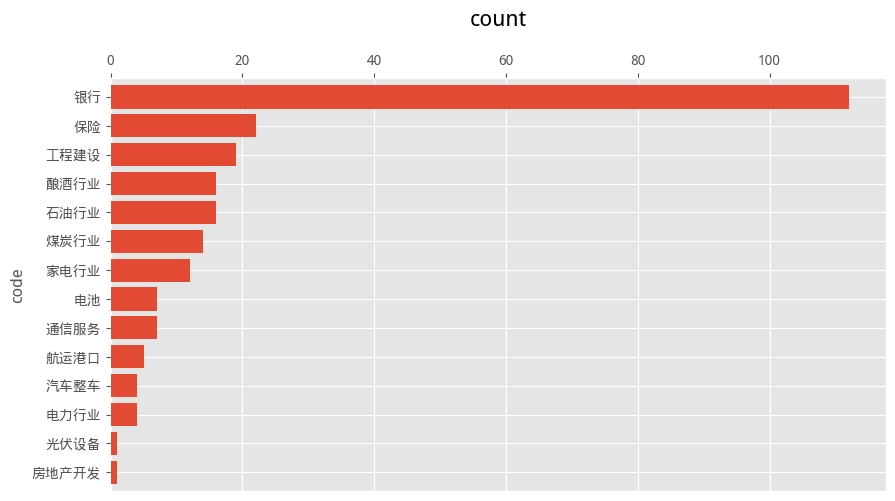

'------所有上过榜的------'

total: 864 | from 55 to 1


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">中国铁建 55",".html"" target=""_blank"">广发证券 55",".html"" target=""_blank"">美的集团 55",".html"" target=""_blank"">中国化学 55",".html"" target=""_blank"">特变电工 55",".html"" target=""_blank"">建发股份 55",".html"" target=""_blank"">兴业银行 55",".html"" target=""_blank"">浦发银行 55"
1,".html"" target=""_blank"">中信银行 55",".html"" target=""_blank"">招商银行 55",".html"" target=""_blank"">万华化学 55",".html"" target=""_blank"">交通银行 55",".html"" target=""_blank"">中国石化 55",".html"" target=""_blank"">中国中车 55",".html"" target=""_blank"">格力电器 55",".html"" target=""_blank"">华域汽车 55"
2,".html"" target=""_blank"">上汽集团 55",".html"" target=""_blank"">工商银行 55",".html"" target=""_blank"">正泰电器 55",".html"" target=""_blank"">建设银行 55",".html"" target=""_blank"">中国银行 55",".html"" target=""_blank"">恒瑞医药 55",".html"" target=""_blank"">民生银行 55",".html"" target=""_blank"">宁沪高速 55"
3,".html"" target=""_blank"">广汽集团 55",".html"" target=""_blank"">海尔智家 55",".html"" target=""_blank"">双汇发展 55",".html"" target=""_blank"">海康威视 55",".html"" target=""_blank"">云南白药 55",".html"" target=""_blank"">紫金矿业 55",".html"" target=""_blank"">招商证券 55",".html"" target=""_blank"">五粮液 55"
4,".html"" target=""_blank"">北京银行 55",".html"" target=""_blank"">中国中铁 55",".html"" target=""_blank"">潍柴动力 55",".html"" target=""_blank"">长江电力 55",".html"" target=""_blank"">光大银行 55",".html"" target=""_blank"">大秦铁路 55",".html"" target=""_blank"">中国交建 55",".html"" target=""_blank"">中国建筑 55"
5,".html"" target=""_blank"">中国太保 55",".html"" target=""_blank"">华泰证券 55",".html"" target=""_blank"">中国平安 55",".html"" target=""_blank"">国电南瑞 55",".html"" target=""_blank"">农业银行 55",".html"" target=""_blank"">华夏银行 55",".html"" target=""_blank"">中信证券 55",".html"" target=""_blank"">中国电信 55"
6,".html"" target=""_blank"">中国人寿 55",".html"" target=""_blank"">中国神华 55",".html"" target=""_blank"">伊利股份 55",".html"" target=""_blank"">泸州老窖 55",".html"" target=""_blank"">中国电建 55",".html"" target=""_blank"">南京银行 55",".html"" target=""_blank"">宁波银行 55",".html"" target=""_blank"">山东高速 55"
7,".html"" target=""_blank"">福耀玻璃 55",".html"" target=""_blank"">上海医药 55",".html"" target=""_blank"">海螺水泥 55",".html"" target=""_blank"">上港集团 55",".html"" target=""_blank"">平安银行 55",".html"" target=""_blank"">宝钢股份 55",".html"" target=""_blank"">保利发展 55",".html"" target=""_blank"">贵州茅台 55"
8,".html"" target=""_blank"">中国核电 55",".html"" target=""_blank"">宁波港 55",".html"" target=""_blank"">洋河股份 55",".html"" target=""_blank"">长城汽车 54",".html"" target=""_blank"">万科A 54",".html"" target=""_blank"">中国石油 54",".html"" target=""_blank"">复星医药 53",".html"" target=""_blank"">隧道股份 53"
9,".html"" target=""_blank"">金地集团 52",".html"" target=""_blank"">中国中免 52",".html"" target=""_blank"">兖矿能源 52",".html"" target=""_blank"">海通证券 52",".html"" target=""_blank"">华能水电 52",".html"" target=""_blank"">新华保险 52",".html"" target=""_blank"">南山铝业 51",".html"" target=""_blank"">雅戈尔 51"


total: 82 | top 20 : 53.24%


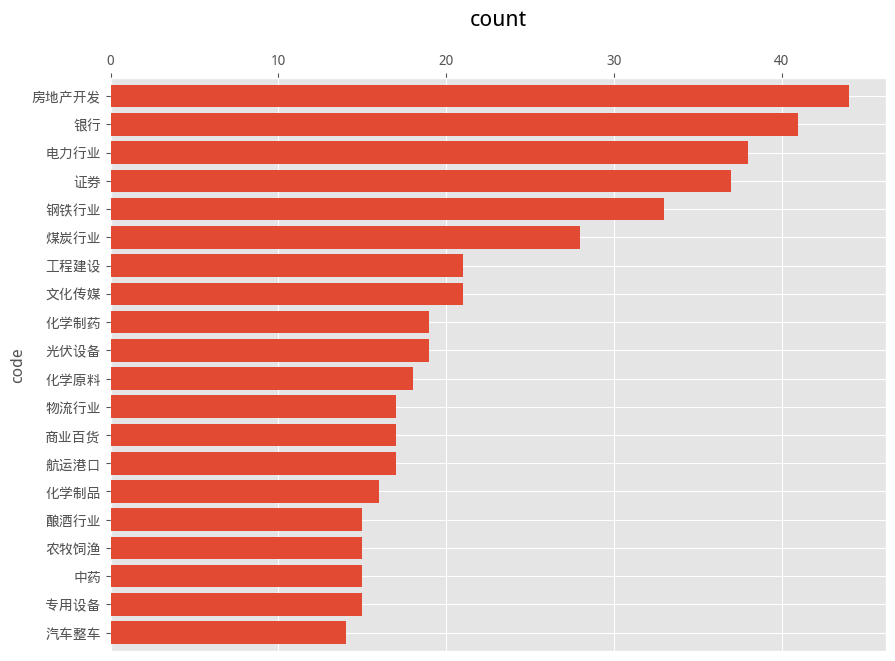

'------每期都上榜的------'

total: 111 | from 55 to 8


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">平安银行",".html"" target=""_blank"">上港集团",".html"" target=""_blank"">海螺水泥",".html"" target=""_blank"">上海医药",".html"" target=""_blank"">福耀玻璃",".html"" target=""_blank"">山东高速",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">南京银行"
1,".html"" target=""_blank"">中国电建",".html"" target=""_blank"">泸州老窖",".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">宁波港",".html"" target=""_blank"">中国核电",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">保利发展",".html"" target=""_blank"">宝钢股份"
2,".html"" target=""_blank"">华域汽车",".html"" target=""_blank"">中国中车",".html"" target=""_blank"">格力电器",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">美的集团",".html"" target=""_blank"">中国化学",".html"" target=""_blank"">特变电工"
3,".html"" target=""_blank"">建发股份",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">中信银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">万华化学",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">中国石化"
4,".html"" target=""_blank"">农业银行",".html"" target=""_blank"">国电南瑞",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">上汽集团",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">正泰电器",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行"
5,".html"" target=""_blank"">恒瑞医药",".html"" target=""_blank"">民生银行",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">广汽集团",".html"" target=""_blank"">海尔智家",".html"" target=""_blank"">双汇发展",".html"" target=""_blank"">海康威视",".html"" target=""_blank"">云南白药"
6,".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">中国神华",".html"" target=""_blank"">伊利股份",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">中国太保",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">中国交建",".html"" target=""_blank"">大秦铁路"
7,".html"" target=""_blank"">光大银行",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">潍柴动力",".html"" target=""_blank"">中国中铁",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">中国电信",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">华夏银行"
8,".html"" target=""_blank"">紫金矿业",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">长城汽车",".html"" target=""_blank"">新华保险",".html"" target=""_blank"">海天味业",".html"" target=""_blank"">国信证券",".html"" target=""_blank"">申万宏源"
9,".html"" target=""_blank"">国泰君安",".html"" target=""_blank"">龙源电力",".html"" target=""_blank"">中国广核",".html"" target=""_blank"">招商蛇口",".html"" target=""_blank"">贵阳银行",".html"" target=""_blank"">齐鲁银行",".html"" target=""_blank"">江苏银行",".html"" target=""_blank"">杭州银行"


total: 34 | top 20 : 87.39%


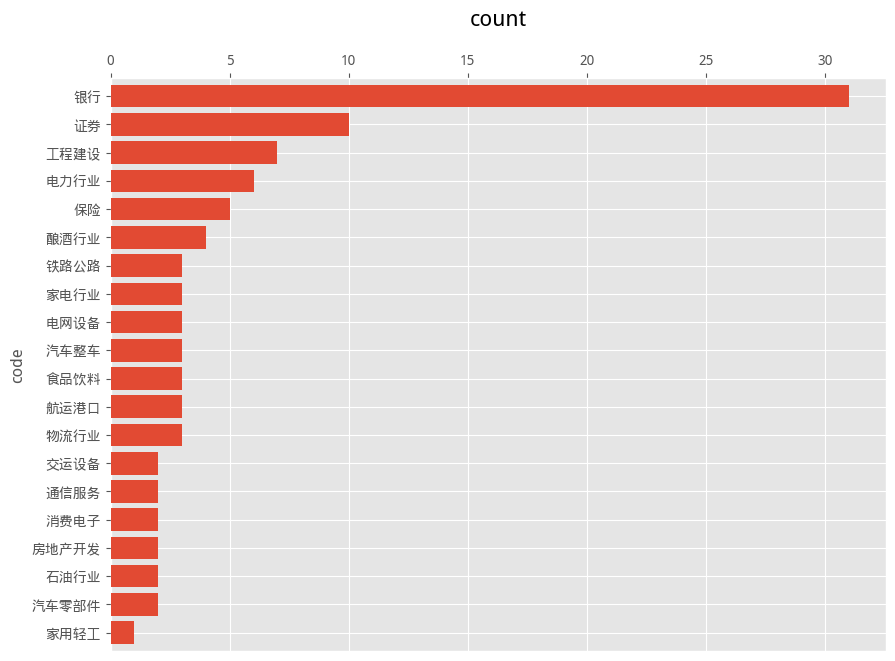

'------增长情况------'

'增长top300'

total: 300 | from 0.93 to 0.26


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">宁波银行 0.93",".html"" target=""_blank"">心脉医疗 0.93",".html"" target=""_blank"">迈瑞医疗 0.93",".html"" target=""_blank"">唐山港 0.89",".html"" target=""_blank"">同仁堂 0.84",".html"" target=""_blank"">中国建筑 0.83",".html"" target=""_blank"">安图生物 0.80",".html"" target=""_blank"">胜宏科技 0.78"
1,".html"" target=""_blank"">恩华药业 0.77",".html"" target=""_blank"">柯力传感 0.74",".html"" target=""_blank"">汉得信息 0.69",".html"" target=""_blank"">南京银行 0.69",".html"" target=""_blank"">中微公司 0.69",".html"" target=""_blank"">普门科技 0.67",".html"" target=""_blank"">光威复材 0.67",".html"" target=""_blank"">中国电研 0.67"
2,".html"" target=""_blank"">联环药业 0.64",".html"" target=""_blank"">盘龙药业 0.63",".html"" target=""_blank"">青鸟消防 0.63",".html"" target=""_blank"">齐鲁银行 0.62",".html"" target=""_blank"">健友股份 0.62",".html"" target=""_blank"">亿联网络 0.62",".html"" target=""_blank"">长沙银行 0.60",".html"" target=""_blank"">北京银行 0.60"
3,".html"" target=""_blank"">珀莱雅 0.60",".html"" target=""_blank"">迈为股份 0.59",".html"" target=""_blank"">东阿阿胶 0.59",".html"" target=""_blank"">比音勒芬 0.59",".html"" target=""_blank"">海康威视 0.55",".html"" target=""_blank"">中国铁建 0.55",".html"" target=""_blank"">景津装备 0.55",".html"" target=""_blank"">平安银行 0.55"
4,".html"" target=""_blank"">美亚光电 0.55",".html"" target=""_blank"">航天电器 0.54",".html"" target=""_blank"">老百姓 0.54",".html"" target=""_blank"">金牌家居 0.53",".html"" target=""_blank"">信质集团 0.53",".html"" target=""_blank"">中文传媒 0.52",".html"" target=""_blank"">威胜信息 0.52",".html"" target=""_blank"">富安娜 0.52"
5,".html"" target=""_blank"">伊利股份 0.52",".html"" target=""_blank"">机器人 0.51",".html"" target=""_blank"">正海生物 0.51",".html"" target=""_blank"">皇马科技 0.50",".html"" target=""_blank"">新华文轩 0.50",".html"" target=""_blank"">启迪环境 0.50",".html"" target=""_blank"">兴业银行 0.50",".html"" target=""_blank"">利安隆 0.49"
6,".html"" target=""_blank"">成都银行 0.49",".html"" target=""_blank"">龙软科技 0.48",".html"" target=""_blank"">常熟银行 0.48",".html"" target=""_blank"">浦发银行 0.48",".html"" target=""_blank"">海天味业 0.47",".html"" target=""_blank"">欧派家居 0.47",".html"" target=""_blank"">广和通 0.47",".html"" target=""_blank"">密尔克卫 0.47"
7,".html"" target=""_blank"">奇正藏药 0.47",".html"" target=""_blank"">特宝生物 0.46",".html"" target=""_blank"">龙净环保 0.46",".html"" target=""_blank"">我武生物 0.46",".html"" target=""_blank"">招商银行 0.46",".html"" target=""_blank"">信立泰 0.45",".html"" target=""_blank"">美的集团 0.45",".html"" target=""_blank"">林洋能源 0.45"
8,".html"" target=""_blank"">艾德生物 0.45",".html"" target=""_blank"">中电环保 0.45",".html"" target=""_blank"">诺力股份 0.45",".html"" target=""_blank"">七一二 0.44",".html"" target=""_blank"">欧普康视 0.44",".html"" target=""_blank"">新城控股 0.44",".html"" target=""_blank"">中原内配 0.44",".html"" target=""_blank"">安集科技 0.43"
9,".html"" target=""_blank"">良信股份 0.43",".html"" target=""_blank"">老凤祥 0.43",".html"" target=""_blank"">凌霄泵业 0.43",".html"" target=""_blank"">久远银海 0.43",".html"" target=""_blank"">铂科新材 0.43",".html"" target=""_blank"">益丰药房 0.43",".html"" target=""_blank"">基康仪器 0.42",".html"" target=""_blank"">科锐国际 0.42"


total: 63 | top 20 : 66.33%


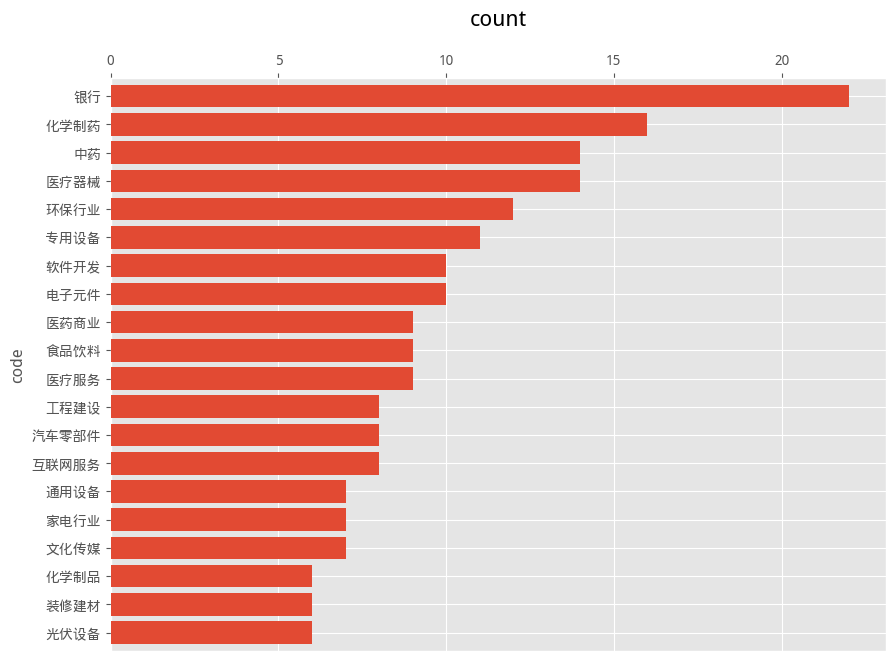

'增长top300,同时上榜过profit top300'

total: 100 | from 0.93 to 0.26


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">宁波银行 0.93",".html"" target=""_blank"">迈瑞医疗 0.93",".html"" target=""_blank"">唐山港 0.89",".html"" target=""_blank"">同仁堂 0.84",".html"" target=""_blank"">中国建筑 0.83",".html"" target=""_blank"">南京银行 0.69",".html"" target=""_blank"">齐鲁银行 0.62",".html"" target=""_blank"">亿联网络 0.62"
1,".html"" target=""_blank"">长沙银行 0.60",".html"" target=""_blank"">北京银行 0.60",".html"" target=""_blank"">东阿阿胶 0.59",".html"" target=""_blank"">海康威视 0.55",".html"" target=""_blank"">中国铁建 0.55",".html"" target=""_blank"">平安银行 0.55",".html"" target=""_blank"">中文传媒 0.52",".html"" target=""_blank"">伊利股份 0.52"
2,".html"" target=""_blank"">新华文轩 0.50",".html"" target=""_blank"">启迪环境 0.50",".html"" target=""_blank"">兴业银行 0.50",".html"" target=""_blank"">成都银行 0.49",".html"" target=""_blank"">常熟银行 0.48",".html"" target=""_blank"">浦发银行 0.48",".html"" target=""_blank"">海天味业 0.47",".html"" target=""_blank"">欧派家居 0.47"
3,".html"" target=""_blank"">招商银行 0.46",".html"" target=""_blank"">信立泰 0.45",".html"" target=""_blank"">美的集团 0.45",".html"" target=""_blank"">新城控股 0.44",".html"" target=""_blank"">老凤祥 0.43",".html"" target=""_blank"">大华股份 0.41",".html"" target=""_blank"">杭州银行 0.41",".html"" target=""_blank"">江苏金租 0.41"
4,".html"" target=""_blank"">云南白药 0.40",".html"" target=""_blank"">正泰电器 0.39",".html"" target=""_blank"">伟明环保 0.39",".html"" target=""_blank"">无锡银行 0.39",".html"" target=""_blank"">汇川技术 0.39",".html"" target=""_blank"">捷佳伟创 0.39",".html"" target=""_blank"">上海银行 0.39",".html"" target=""_blank"">视源股份 0.38"
5,".html"" target=""_blank"">上海医药 0.38",".html"" target=""_blank"">利源股份 0.37",".html"" target=""_blank"">万科A 0.37",".html"" target=""_blank"">济川药业 0.37",".html"" target=""_blank"">苏泊尔 0.37",".html"" target=""_blank"">新天绿能 0.37",".html"" target=""_blank"">华夏银行 0.36",".html"" target=""_blank"">老板电器 0.36"
6,".html"" target=""_blank"">国药一致 0.36",".html"" target=""_blank"">白云山 0.36",".html"" target=""_blank"">东方雨虹 0.35",".html"" target=""_blank"">中国中铁 0.35",".html"" target=""_blank"">江苏银行 0.35",".html"" target=""_blank"">先导智能 0.35",".html"" target=""_blank"">凯莱英 0.35",".html"" target=""_blank"">公牛集团 0.34"
7,".html"" target=""_blank"">中国核建 0.34",".html"" target=""_blank"">恒瑞医药 0.34",".html"" target=""_blank"">复星医药 0.33",".html"" target=""_blank"">保利发展 0.33",".html"" target=""_blank"">隧道股份 0.33",".html"" target=""_blank"">华东医药 0.33",".html"" target=""_blank"">光大银行 0.32",".html"" target=""_blank"">深圳燃气 0.31"
8,".html"" target=""_blank"">农业银行 0.31",".html"" target=""_blank"">中南传媒 0.31",".html"" target=""_blank"">华夏幸福 0.31",".html"" target=""_blank"">福莱特 0.31",".html"" target=""_blank"">格力电器 0.31",".html"" target=""_blank"">上海建工 0.31",".html"" target=""_blank"">白云机场 0.30",".html"" target=""_blank"">中国银行 0.30"
9,".html"" target=""_blank"">中国医药 0.30",".html"" target=""_blank"">建设银行 0.30",".html"" target=""_blank"">振华科技 0.30",".html"" target=""_blank"">康美药业 0.30",".html"" target=""_blank"">中国外运 0.29",".html"" target=""_blank"">片仔癀 0.29",".html"" target=""_blank"">口子窖 0.29",".html"" target=""_blank"">华域汽车 0.29"


total: 36 | top 20 : 84.00%


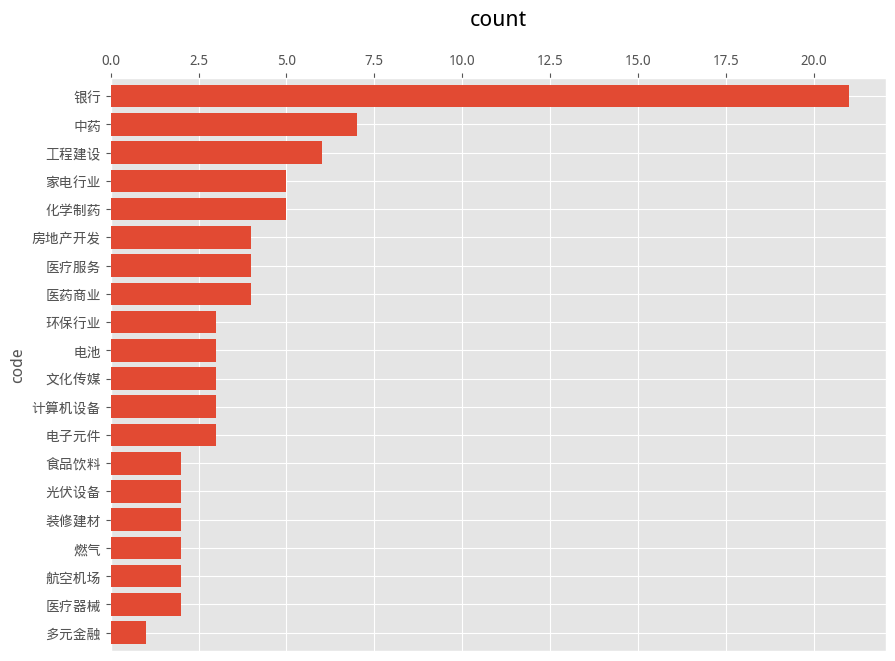

'增长top300,同时profit一直top300'

total: 39 | from 0.93 to 0.27


,1,2,3,4,5,6,7,8
0,".html"" target=""_blank"">宁波银行 0.93",".html"" target=""_blank"">迈瑞医疗 0.93",".html"" target=""_blank"">中国建筑 0.83",".html"" target=""_blank"">南京银行 0.69",".html"" target=""_blank"">齐鲁银行 0.62",".html"" target=""_blank"">长沙银行 0.60",".html"" target=""_blank"">北京银行 0.60",".html"" target=""_blank"">海康威视 0.55"
1,".html"" target=""_blank"">中国铁建 0.55",".html"" target=""_blank"">平安银行 0.55",".html"" target=""_blank"">伊利股份 0.52",".html"" target=""_blank"">兴业银行 0.50",".html"" target=""_blank"">成都银行 0.49",".html"" target=""_blank"">浦发银行 0.48",".html"" target=""_blank"">海天味业 0.47",".html"" target=""_blank"">招商银行 0.46"
2,".html"" target=""_blank"">美的集团 0.45",".html"" target=""_blank"">杭州银行 0.41",".html"" target=""_blank"">云南白药 0.40",".html"" target=""_blank"">正泰电器 0.39",".html"" target=""_blank"">上海银行 0.39",".html"" target=""_blank"">上海医药 0.38",".html"" target=""_blank"">华夏银行 0.36",".html"" target=""_blank"">中国中铁 0.35"
3,".html"" target=""_blank"">江苏银行 0.35",".html"" target=""_blank"">公牛集团 0.34",".html"" target=""_blank"">恒瑞医药 0.34",".html"" target=""_blank"">保利发展 0.33",".html"" target=""_blank"">光大银行 0.32",".html"" target=""_blank"">农业银行 0.31",".html"" target=""_blank"">格力电器 0.31",".html"" target=""_blank"">中国银行 0.30"
4,".html"" target=""_blank"">建设银行 0.30",".html"" target=""_blank"">中国外运 0.29",".html"" target=""_blank"">华域汽车 0.29",".html"" target=""_blank"">中国平安 0.28",".html"" target=""_blank"">贵阳银行 0.27",".html"" target=""_blank"">上汽集团 0.27",".html"" target=""_blank"">海尔智家 0.27",


total: 16 | top 16 : 100.00%


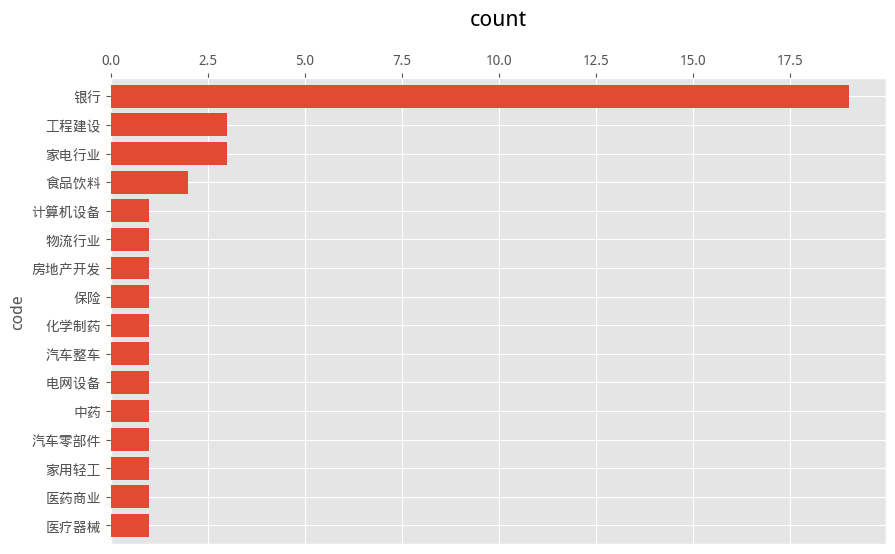

In [8]:
for i in yjbb.profit[1:]:
    i()

## 收入和利润

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">浙江龙盛",".html"" target=""_blank"">上海医药",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">亨通光电",".html"" target=""_blank"">ST中泰",".html"" target=""_blank"">湖北宜化",".html"" target=""_blank"">紫江企业",".html"" target=""_blank"">供销大集"
1,".html"" target=""_blank"">申通快递",".html"" target=""_blank"">绿地控股",".html"" target=""_blank"">杭钢股份",".html"" target=""_blank"">五矿资本",".html"" target=""_blank"">中国通号",".html"" target=""_blank"">光大证券",".html"" target=""_blank"">皖能电力",".html"" target=""_blank"">凌钢股份"
2,".html"" target=""_blank"">东方证券",".html"" target=""_blank"">中海油服",".html"" target=""_blank"">广深铁路",".html"" target=""_blank"">智飞生物",".html"" target=""_blank"">方大特钢",".html"" target=""_blank"">神火股份",".html"" target=""_blank"">淮北矿业",".html"" target=""_blank"">上海银行"
3,".html"" target=""_blank"">通威股份",".html"" target=""_blank"">航发动力",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">厦门钨业",".html"" target=""_blank"">北方稀土",".html"" target=""_blank"">山西焦煤",".html"" target=""_blank"">中铝国际",".html"" target=""_blank"">包钢股份"
4,".html"" target=""_blank"">中国能建",".html"" target=""_blank"">中绿电",".html"" target=""_blank"">广汇能源",".html"" target=""_blank"">大悦城",".html"" target=""_blank"">海南橡胶",".html"" target=""_blank"">歌尔股份",".html"" target=""_blank"">南山铝业",".html"" target=""_blank"">桂冠电力"
5,".html"" target=""_blank"">鲁西化工",".html"" target=""_blank"">康美药业",".html"" target=""_blank"">长源电力",".html"" target=""_blank"">中国核建",".html"" target=""_blank"">海大集团",".html"" target=""_blank"">中国铁物",".html"" target=""_blank"">中工国际",".html"" target=""_blank"">领益智造"
6,".html"" target=""_blank"">牧原股份",".html"" target=""_blank"">中国核电",".html"" target=""_blank"">山东黄金",".html"" target=""_blank"">中油工程",".html"" target=""_blank"">上海机电",".html"" target=""_blank"">厦门象屿",".html"" target=""_blank"">信达地产",".html"" target=""_blank"">华谊集团"
7,".html"" target=""_blank"">美的集团",".html"" target=""_blank"">浙能电力",".html"" target=""_blank"">东山精密",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">飞马国际",".html"" target=""_blank"">赣锋锂业",".html"" target=""_blank"">大华股份",".html"" target=""_blank"">五矿发展"
8,".html"" target=""_blank"">申万宏源",".html"" target=""_blank"">百联股份",".html"" target=""_blank"">长江传媒",".html"" target=""_blank"">宁德时代",".html"" target=""_blank"">中信特钢",".html"" target=""_blank"">传化智联",".html"" target=""_blank"">上海石化",".html"" target=""_blank"">中国石化"
9,".html"" target=""_blank"">首钢股份",".html"" target=""_blank"">柳钢股份",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">大商股份",".html"" target=""_blank"">中国船舶",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">*ST金科",".html"" target=""_blank"">中兴通讯"


total: 72 | top 20 : 61.93%


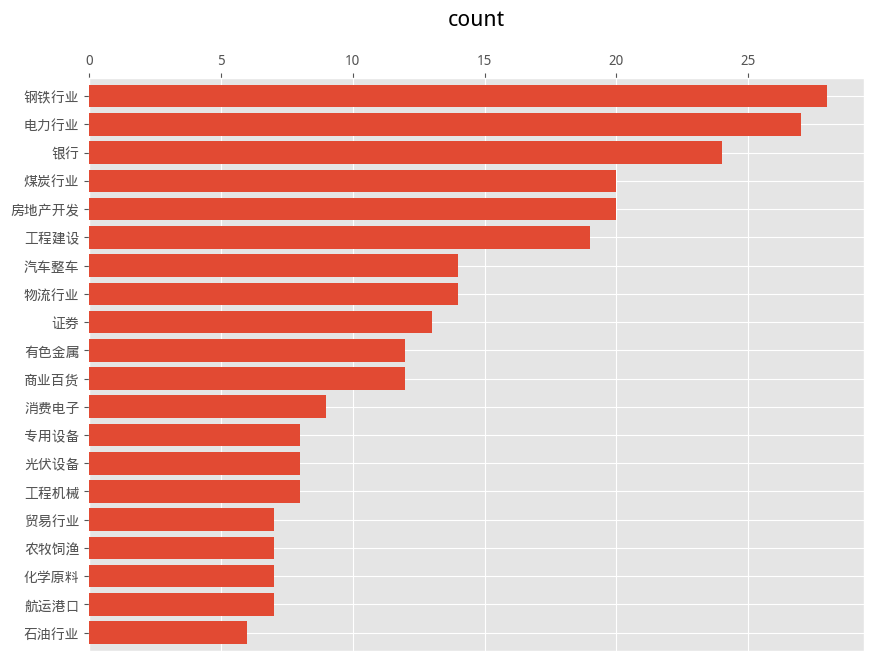

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">民生银行",".html"" target=""_blank"">工业富联",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">中国中车",".html"" target=""_blank"">上海医药",".html"" target=""_blank"">浙商银行",".html"" target=""_blank"">中国人保",".html"" target=""_blank"">中国海油"
1,".html"" target=""_blank"">美的集团",".html"" target=""_blank"">格力电器",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国能建",".html"" target=""_blank"">中国化学",".html"" target=""_blank"">华域汽车",".html"" target=""_blank"">宝钢股份"
2,".html"" target=""_blank"">上汽集团",".html"" target=""_blank"">大秦铁路",".html"" target=""_blank"">平安银行",".html"" target=""_blank"">双汇发展",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">紫金矿业",".html"" target=""_blank"">伊利股份",".html"" target=""_blank"">海尔智家"
3,".html"" target=""_blank"">中国移动",".html"" target=""_blank"">长城汽车",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">招商蛇口",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">云南白药",".html"" target=""_blank"">中信银行"
4,".html"" target=""_blank"">招商银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">中国交建",".html"" target=""_blank"">中国广核",".html"" target=""_blank"">万华化学",".html"" target=""_blank"">特变电工",".html"" target=""_blank"">新华保险",".html"" target=""_blank"">农业银行"
5,".html"" target=""_blank"">龙源电力",".html"" target=""_blank"">江苏银行",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">中国太保",".html"" target=""_blank"">宁德时代",".html"" target=""_blank"">保利发展",".html"" target=""_blank"">邮储银行",".html"" target=""_blank"">华夏银行"
6,".html"" target=""_blank"">建发股份",".html"" target=""_blank"">广汽集团",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">华勤技术",".html"" target=""_blank"">中国电信",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">中国石化",".html"" target=""_blank"">潍柴动力"
7,".html"" target=""_blank"">中国电建",".html"" target=""_blank"">中国人寿",".html"" target=""_blank"">中国铁建",".html"" target=""_blank"">中国外运",".html"" target=""_blank"">中国神华",".html"" target=""_blank"">中国核电",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">中国中铁"
8,".html"" target=""_blank"">上海银行",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">海螺水泥",,,,


total: 26 | top 20 : 91.18%


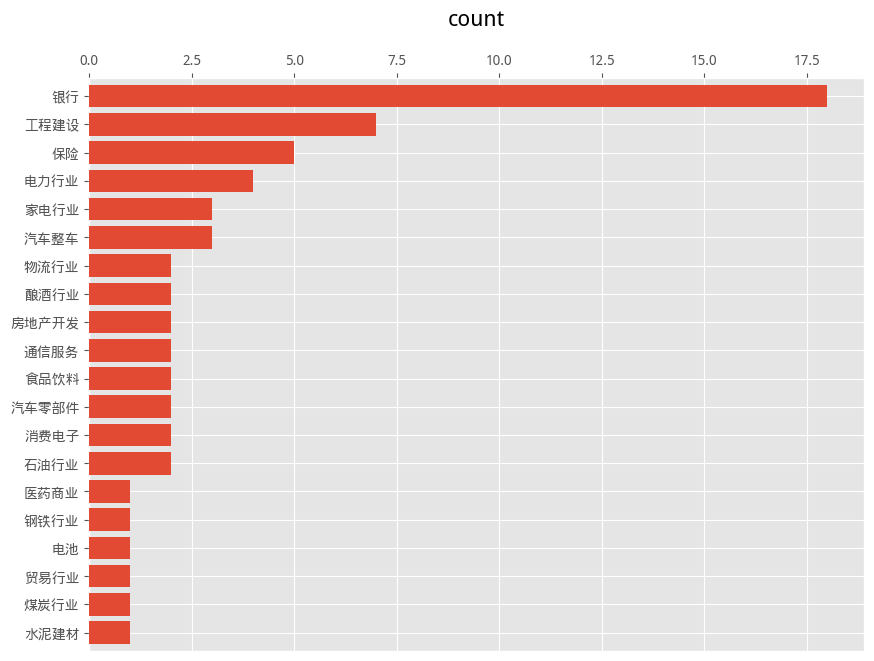

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">上海医药",".html"" target=""_blank"">杭州银行",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">机器人",".html"" target=""_blank"">心脉医疗",".html"" target=""_blank"">恩华药业",".html"" target=""_blank"">景旺电子",".html"" target=""_blank"">万达信息"
1,".html"" target=""_blank"">数字政通",".html"" target=""_blank"">常熟银行",".html"" target=""_blank"">上汽集团",".html"" target=""_blank"">珀莱雅",".html"" target=""_blank"">复星医药",".html"" target=""_blank"">万科A",".html"" target=""_blank"">安科生物",".html"" target=""_blank"">顺络电子"
2,".html"" target=""_blank"">广州酒家",".html"" target=""_blank"">基蛋生物",".html"" target=""_blank"">昆药集团",".html"" target=""_blank"">芯源微",".html"" target=""_blank"">南微医学",".html"" target=""_blank"">健友股份",".html"" target=""_blank"">启明星辰",".html"" target=""_blank"">宁波银行"
3,".html"" target=""_blank"">康缘药业",".html"" target=""_blank"">英维克",".html"" target=""_blank"">博思软件",".html"" target=""_blank"">龙净环保",".html"" target=""_blank"">中南传媒",".html"" target=""_blank"">欧亚集团",".html"" target=""_blank"">安图生物",".html"" target=""_blank"">汉得信息"
4,".html"" target=""_blank"">深南电路",".html"" target=""_blank"">艾德生物",".html"" target=""_blank"">光威复材",".html"" target=""_blank"">美亚光电",".html"" target=""_blank"">齐鲁银行",".html"" target=""_blank"">阿拉丁",".html"" target=""_blank"">华数传媒",".html"" target=""_blank"">康龙化成"
5,".html"" target=""_blank"">中国医药",".html"" target=""_blank"">平安银行",".html"" target=""_blank"">龙软科技",".html"" target=""_blank"">天准科技",".html"" target=""_blank"">伊利股份",".html"" target=""_blank"">安集科技",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">兴业银行"
6,".html"" target=""_blank"">久远银海",".html"" target=""_blank"">云南白药",".html"" target=""_blank"">山河药辅",".html"" target=""_blank"">新坐标",".html"" target=""_blank"">普门科技",".html"" target=""_blank"">上海建工",".html"" target=""_blank"">华东医药",".html"" target=""_blank"">艾华集团"
7,".html"" target=""_blank"">迈为股份",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">东方电子",".html"" target=""_blank"">广电运通",".html"" target=""_blank"">同仁堂",".html"" target=""_blank"">豪迈科技",".html"" target=""_blank"">润达医疗",".html"" target=""_blank"">弘亚数控"
8,".html"" target=""_blank"">昭衍新药",".html"" target=""_blank"">德赛电池",".html"" target=""_blank"">山东赫达",".html"" target=""_blank"">广和通",".html"" target=""_blank"">能科科技",".html"" target=""_blank"">科锐国际",".html"" target=""_blank"">一心堂",".html"" target=""_blank"">浦发银行"
9,".html"" target=""_blank"">海容冷链",".html"" target=""_blank"">成都银行",".html"" target=""_blank"">迈瑞医疗",".html"" target=""_blank"">中科曙光",".html"" target=""_blank"">裕同科技",".html"" target=""_blank"">亿联网络",".html"" target=""_blank"">金石资源",".html"" target=""_blank"">普利制药"


total: 45 | top 20 : 77.69%


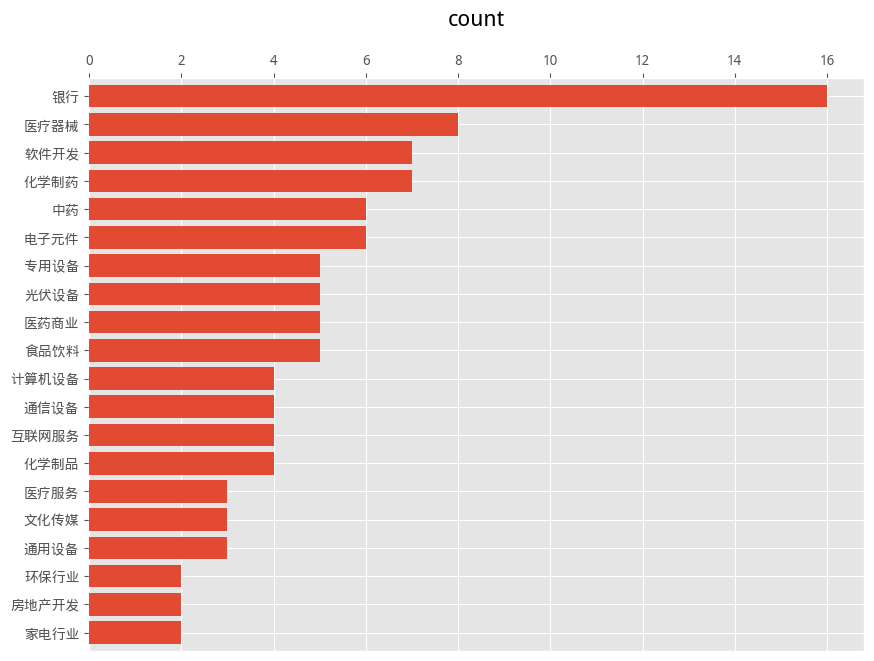

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">上海医药",".html"" target=""_blank"">杭州银行",".html"" target=""_blank"">迈瑞医疗",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">上汽集团",".html"" target=""_blank"">中国医药",".html"" target=""_blank"">复星医药"
1,".html"" target=""_blank"">平安银行",".html"" target=""_blank"">万科A",".html"" target=""_blank"">大华股份",".html"" target=""_blank"">伊利股份",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">上海建工"
2,".html"" target=""_blank"">云南白药",".html"" target=""_blank"">华东医药",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">保利发展",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">中国银行"
3,".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">海康威视",,,,,,


total: 11 | top 11 : 100.00%


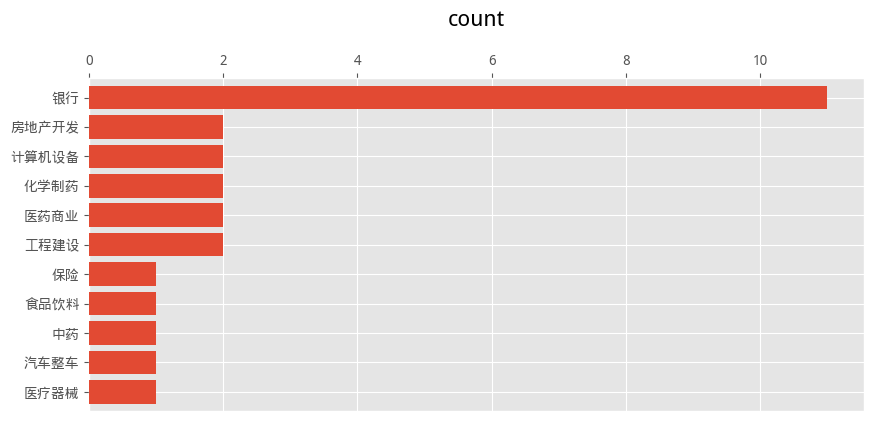

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">光大银行",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">上汽集团",".html"" target=""_blank"">上海医药",".html"" target=""_blank"">中国建筑",".html"" target=""_blank"">平安银行",".html"" target=""_blank"">中国平安",".html"" target=""_blank"">伊利股份"
1,".html"" target=""_blank"">北京银行",".html"" target=""_blank"">保利发展",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">云南白药"
2,,,,,,,,


total: 8 | top 8 : 100.00%


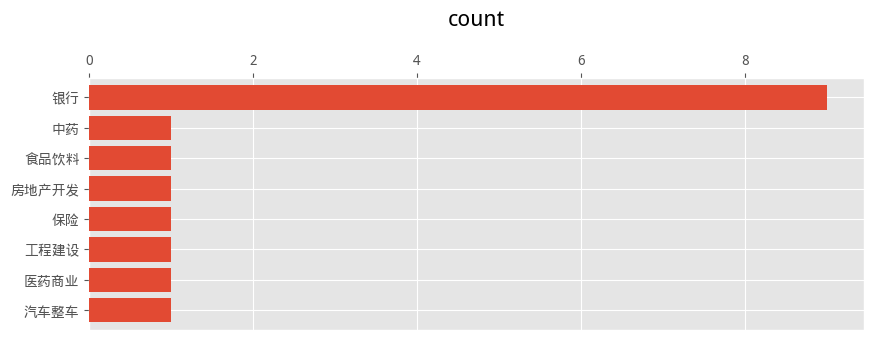

In [9]:
yjbb.cross_rev_pro()

## 利润率

### 每期利润率大于15％的公司数量和比率

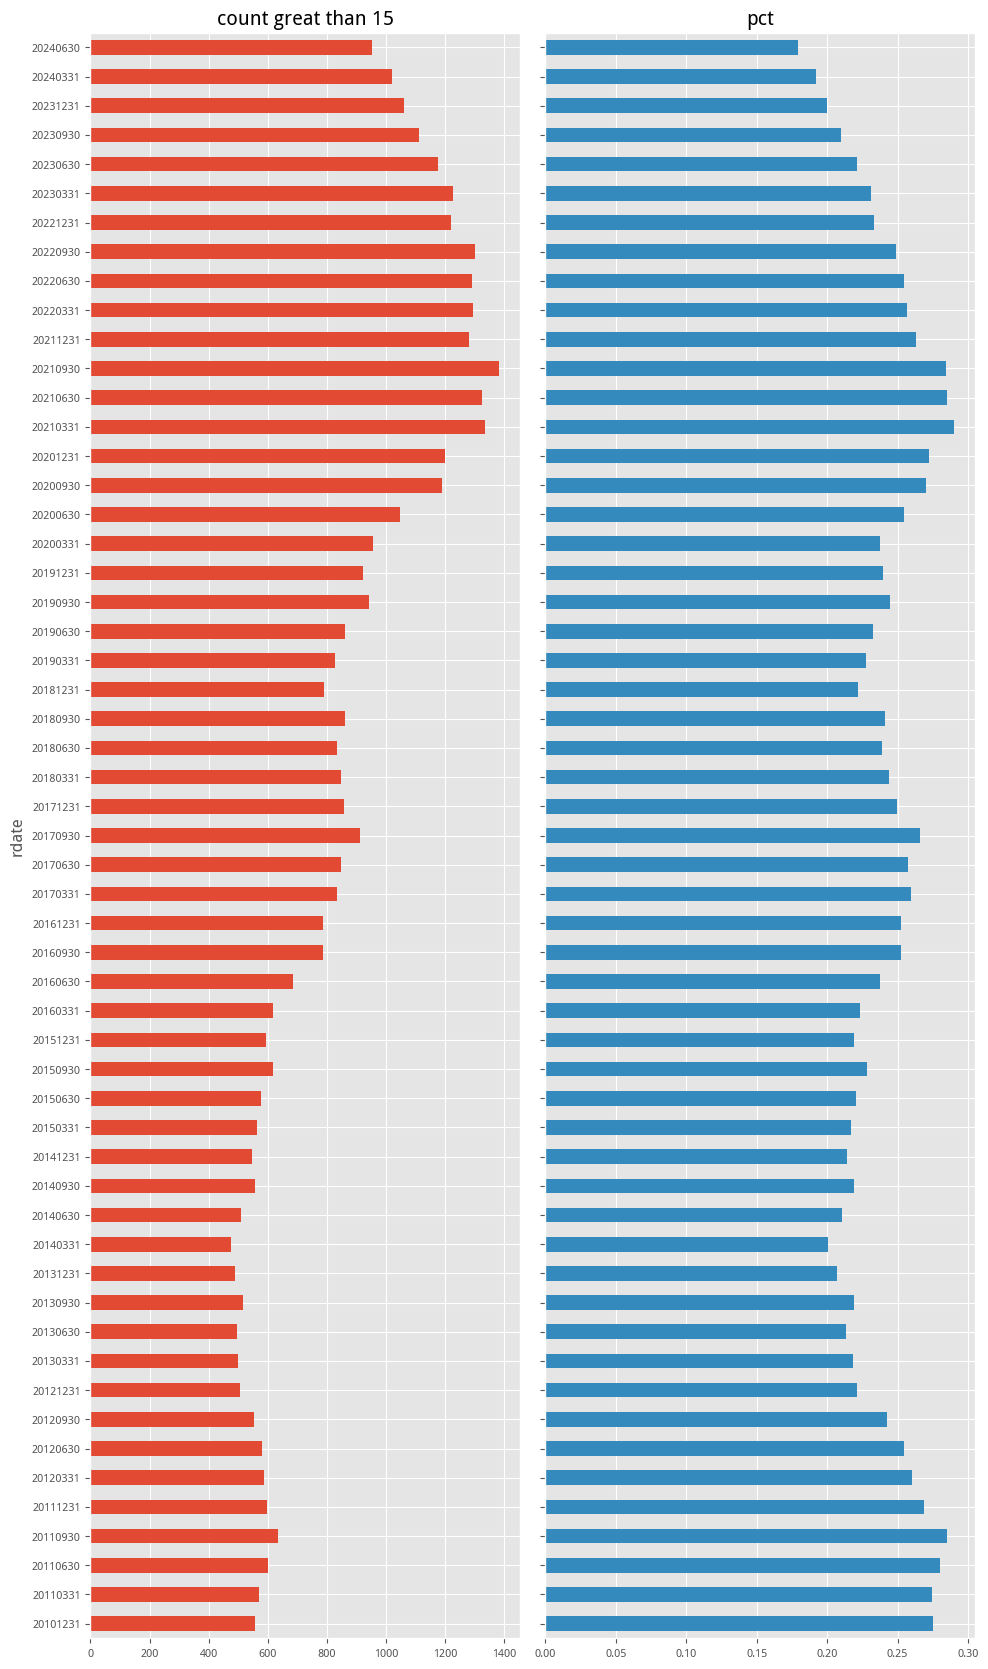

In [10]:
yjbb.gt_per_year()

高利率的企业数量和占比持续恶化，现在是历史最低点。

### 所有期利润率大于15－25的公司数量
基数至少为20期，即至少有5年的数据。

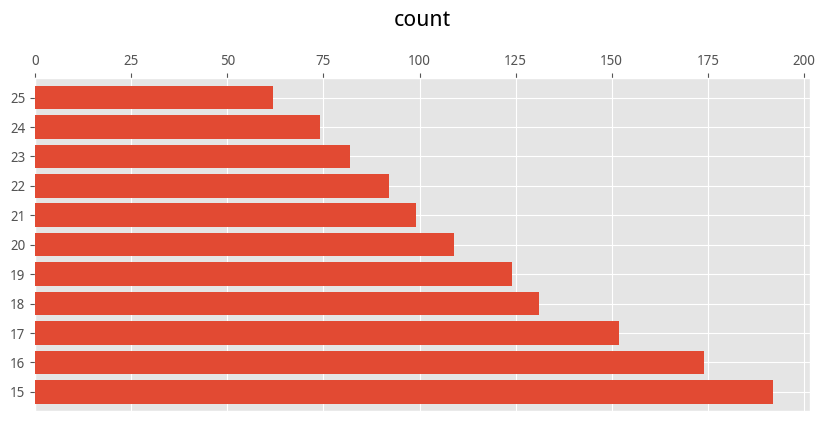

In [11]:
plot_barh(pd.Series([len(yjbb.gt_all_years(n)) for n in range(15, 26)], index=range(15,26)).to_frame('count'))

自有报告开始，每期净利率都大于n的企业家数。

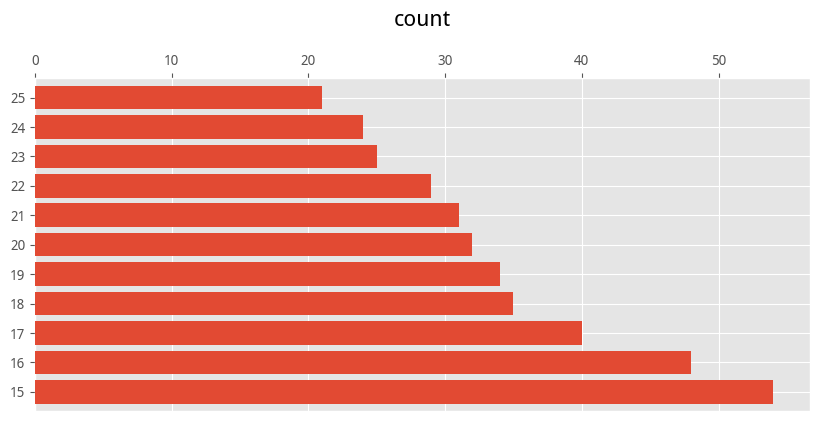

In [12]:
# 自2010年起每期净利率都大于
plot_barh(pd.Series([len(yjbb.gt_all_years(n, 54)) for n in range(15, 26)], index=range(15,26)).to_frame('count'))

自2010年起，每期净利率都大于25％，居然还有25家。

In [13]:
for i in range(15, 25):
    display(f'---所有期利润均大于{i}％---')
    yjbb.fold_list(yjbb.gt_all_years(i, 54)['code'], 8)

'---所有期利润均大于15％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">平安银行",".html"" target=""_blank"">盐田港",".html"" target=""_blank"">陕国投A",".html"" target=""_blank"">泸州老窖",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">中山公用",".html"" target=""_blank"">国元证券"
1,".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">双鹭药业",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">鱼跃医疗",".html"" target=""_blank"">桂林三金",".html"" target=""_blank"">洋河股份"
2,".html"" target=""_blank"">恒基达鑫",".html"" target=""_blank"">豪迈科技",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">民生银行",".html"" target=""_blank"">上港集团",".html"" target=""_blank"">中信证券"
3,".html"" target=""_blank"">福建高速",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">国金证券",".html"" target=""_blank"">联美控股",".html"" target=""_blank"">恒瑞医药",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">片仔癀"
4,".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">深高速",".html"" target=""_blank"">法拉电子",".html"" target=""_blank"">浦东金桥",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">通策医疗",".html"" target=""_blank"">创业环保",".html"" target=""_blank"">长江电力"
5,".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">龙江交通",".html"" target=""_blank"">江南水务",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行"
6,".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行",,


'---所有期利润均大于16％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">平安银行",".html"" target=""_blank"">盐田港",".html"" target=""_blank"">陕国投A",".html"" target=""_blank"">泸州老窖",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">中山公用",".html"" target=""_blank"">国元证券"
1,".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">鱼跃医疗",".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">恒基达鑫",".html"" target=""_blank"">豪迈科技"
2,".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">民生银行",".html"" target=""_blank"">上港集团",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">福建高速",".html"" target=""_blank"">招商银行"
3,".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">联美控股",".html"" target=""_blank"">恒瑞医药",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">片仔癀",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">深高速",".html"" target=""_blank"">法拉电子"
4,".html"" target=""_blank"">浦东金桥",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">江南水务"
5,".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行"
6,,,,,,,,


'---所有期利润均大于17％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">平安银行",".html"" target=""_blank"">盐田港",".html"" target=""_blank"">陕国投A",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液"
1,".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">恒基达鑫",".html"" target=""_blank"">豪迈科技",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行"
2,".html"" target=""_blank"">民生银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">联美控股",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">片仔癀",".html"" target=""_blank"">贵州茅台"
3,".html"" target=""_blank"">法拉电子",".html"" target=""_blank"">浦东金桥",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行"
4,".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行"
5,,,,,,,,


'---所有期利润均大于18％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行"
1,".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">民生银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥"
2,".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">片仔癀",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">法拉电子",".html"" target=""_blank"">浦东金桥",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券"
3,".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行"
4,".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行",,,,,


'---所有期利润均大于19％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行"
1,".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">宁沪高速"
2,".html"" target=""_blank"">片仔癀",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">法拉电子",".html"" target=""_blank"">浦东金桥",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行"
3,".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行"
4,".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行",,,,,,


'---所有期利润均大于20％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">兴蓉环境",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行"
1,".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">宁沪高速"
2,".html"" target=""_blank"">片仔癀",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行"
3,".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行"
4,,,,,,,,


'---所有期利润均大于21％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">洋河股份"
1,".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">片仔癀"
2,".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">农业银行"
3,".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行",


'---所有期利润均大于22％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">洋河股份"
1,".html"" target=""_blank"">皖通高速",".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">宁沪高速",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">川投能源"
2,".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行"
3,".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行",".html"" target=""_blank"">中信银行",,,


'---所有期利润均大于23％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">华兰生物",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">洋河股份"
1,".html"" target=""_blank"">中信证券",".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行"
2,".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行"
3,".html"" target=""_blank"">中国银行",,,,,,,


'---所有期利润均大于24％---'

,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">盐田港",".html"" target=""_blank"">吉林敖东",".html"" target=""_blank"">国元证券",".html"" target=""_blank"">广发证券",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">宁波银行",".html"" target=""_blank"">洋河股份",".html"" target=""_blank"">中信证券"
1,".html"" target=""_blank"">招商银行",".html"" target=""_blank"">重庆路桥",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">川投能源",".html"" target=""_blank"">长江电力",".html"" target=""_blank"">招商证券",".html"" target=""_blank"">南京银行",".html"" target=""_blank"">兴业银行"
2,".html"" target=""_blank"">北京银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">交通银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">华泰证券",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">中国银行"
3,,,,,,,,


In [14]:
# 收入、利润均保持前300，净利率保持15％以上。
res_l = set(yjbb.revenue[0][1]) & set(yjbb.profit[0][1]) & set(yjbb.gt_all_years(15)['code'].to_list())
yjbb.fold_list(res_l, 8)


,0,1,2,3,4,5,6,7
0,".html"" target=""_blank"">民生银行",".html"" target=""_blank"">浦发银行",".html"" target=""_blank"">浙商银行",".html"" target=""_blank"">中信证券",".html"" target=""_blank"">建设银行",".html"" target=""_blank"">平安银行",".html"" target=""_blank"">北京银行",".html"" target=""_blank"">交通银行"
1,".html"" target=""_blank"">招商银行",".html"" target=""_blank"">兴业银行",".html"" target=""_blank"">中信银行",".html"" target=""_blank"">工商银行",".html"" target=""_blank"">农业银行",".html"" target=""_blank"">江苏银行",".html"" target=""_blank"">邮储银行",".html"" target=""_blank"">长江电力"
2,".html"" target=""_blank"">华夏银行",".html"" target=""_blank"">贵州茅台",".html"" target=""_blank"">光大银行",".html"" target=""_blank"">五粮液",".html"" target=""_blank"">上海银行",".html"" target=""_blank"">中国银行",,


In [15]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('2024q2byq.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()